In [1]:
%%capture
!apt-get install -y dvipng texlive-latex-extra texlive-fonts-recommended cm-super 
!pip install SciencePlots tensorflow_addons wandb 
!pip install -q -U tensorflow-text fastai keras_tuner

## Library Imports

In [2]:
import numpy as np # linear algebra
import os
import random
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
import tensorflow_text as text
import tensorflow_hub as hub
import tensorflow.keras.layers as tfl
from tensorflow.keras.metrics import Metric, Precision, Recall
# from tensorflow_addons.metrics import F1Score
from tensorflow_addons.optimizers import AdaBelief
from sklearn.model_selection import train_test_split
import zipfile
import matplotlib.pyplot as plt 
import seaborn as sns
plt.style.reload_library()
plt.style.use(['science', 'ieee', 'no-latex'])
import string
import re
from tensorflow.keras import Sequential, Input
from tensorflow.keras.utils import get_file
import nltk
from nltk.util import ngrams
from nltk.tokenize import TweetTokenizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
import keras_tuner as kt
from tensorflow.keras.regularizers import l2

In [3]:
os.environ['TF_CUDNN_DETERMINISTIC'] = '1' 
random.seed(hash("setting random seeds") % 2**32 - 1)
np.random.seed(hash("improves reproducibility") % 2**32 - 1)
tf.random.set_seed(hash("by removing stochasticity") % 2**32 - 1)

## Import W&B and Login

In [4]:
import wandb
from wandb.keras import WandbCallback

wandb.login()

wandb: Currently logged in as: tiencheng (use `wandb login --relogin` to force relogin)


True

### Settings

In [5]:
#@title Define Hyperparameters
BATCH_SIZE = 64 #@param {type:"integer"}
max_words = 1200000 #@param {type:"integer"}
checkpoint_path = "/tmp/checkpoints" #@param {type:"string"}
save_dir = "saved_model" #@param {type:"string"}

## Data Ingestion

In [6]:
dataset_dir = "/content/drive/MyDrive/Data/DELE CA1/Technical Paper/spell.tsv"
df = pd.read_csv(dataset_dir, sep='\t')
df.head()

,post,class,spellchecked_post
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,"i i "" : jewish harvard professor noel ignatius..."
1,b.higher education is a part of european cult...,not_hate,i higher education is a part of european cultu...
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate,"i has a problem with i "" the whites "" "" and "" ..."
3,is yasir qadhi a hate preacher for calling ch...,not_hate,i is yasir qadi a hate preacher for calling ch...
4,"rt "" : how three million germans mass murder...",not_hate,"i it i "" : how three million germans mass murd..."


Text(0.5, 1.0, 'Class Distribution')

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


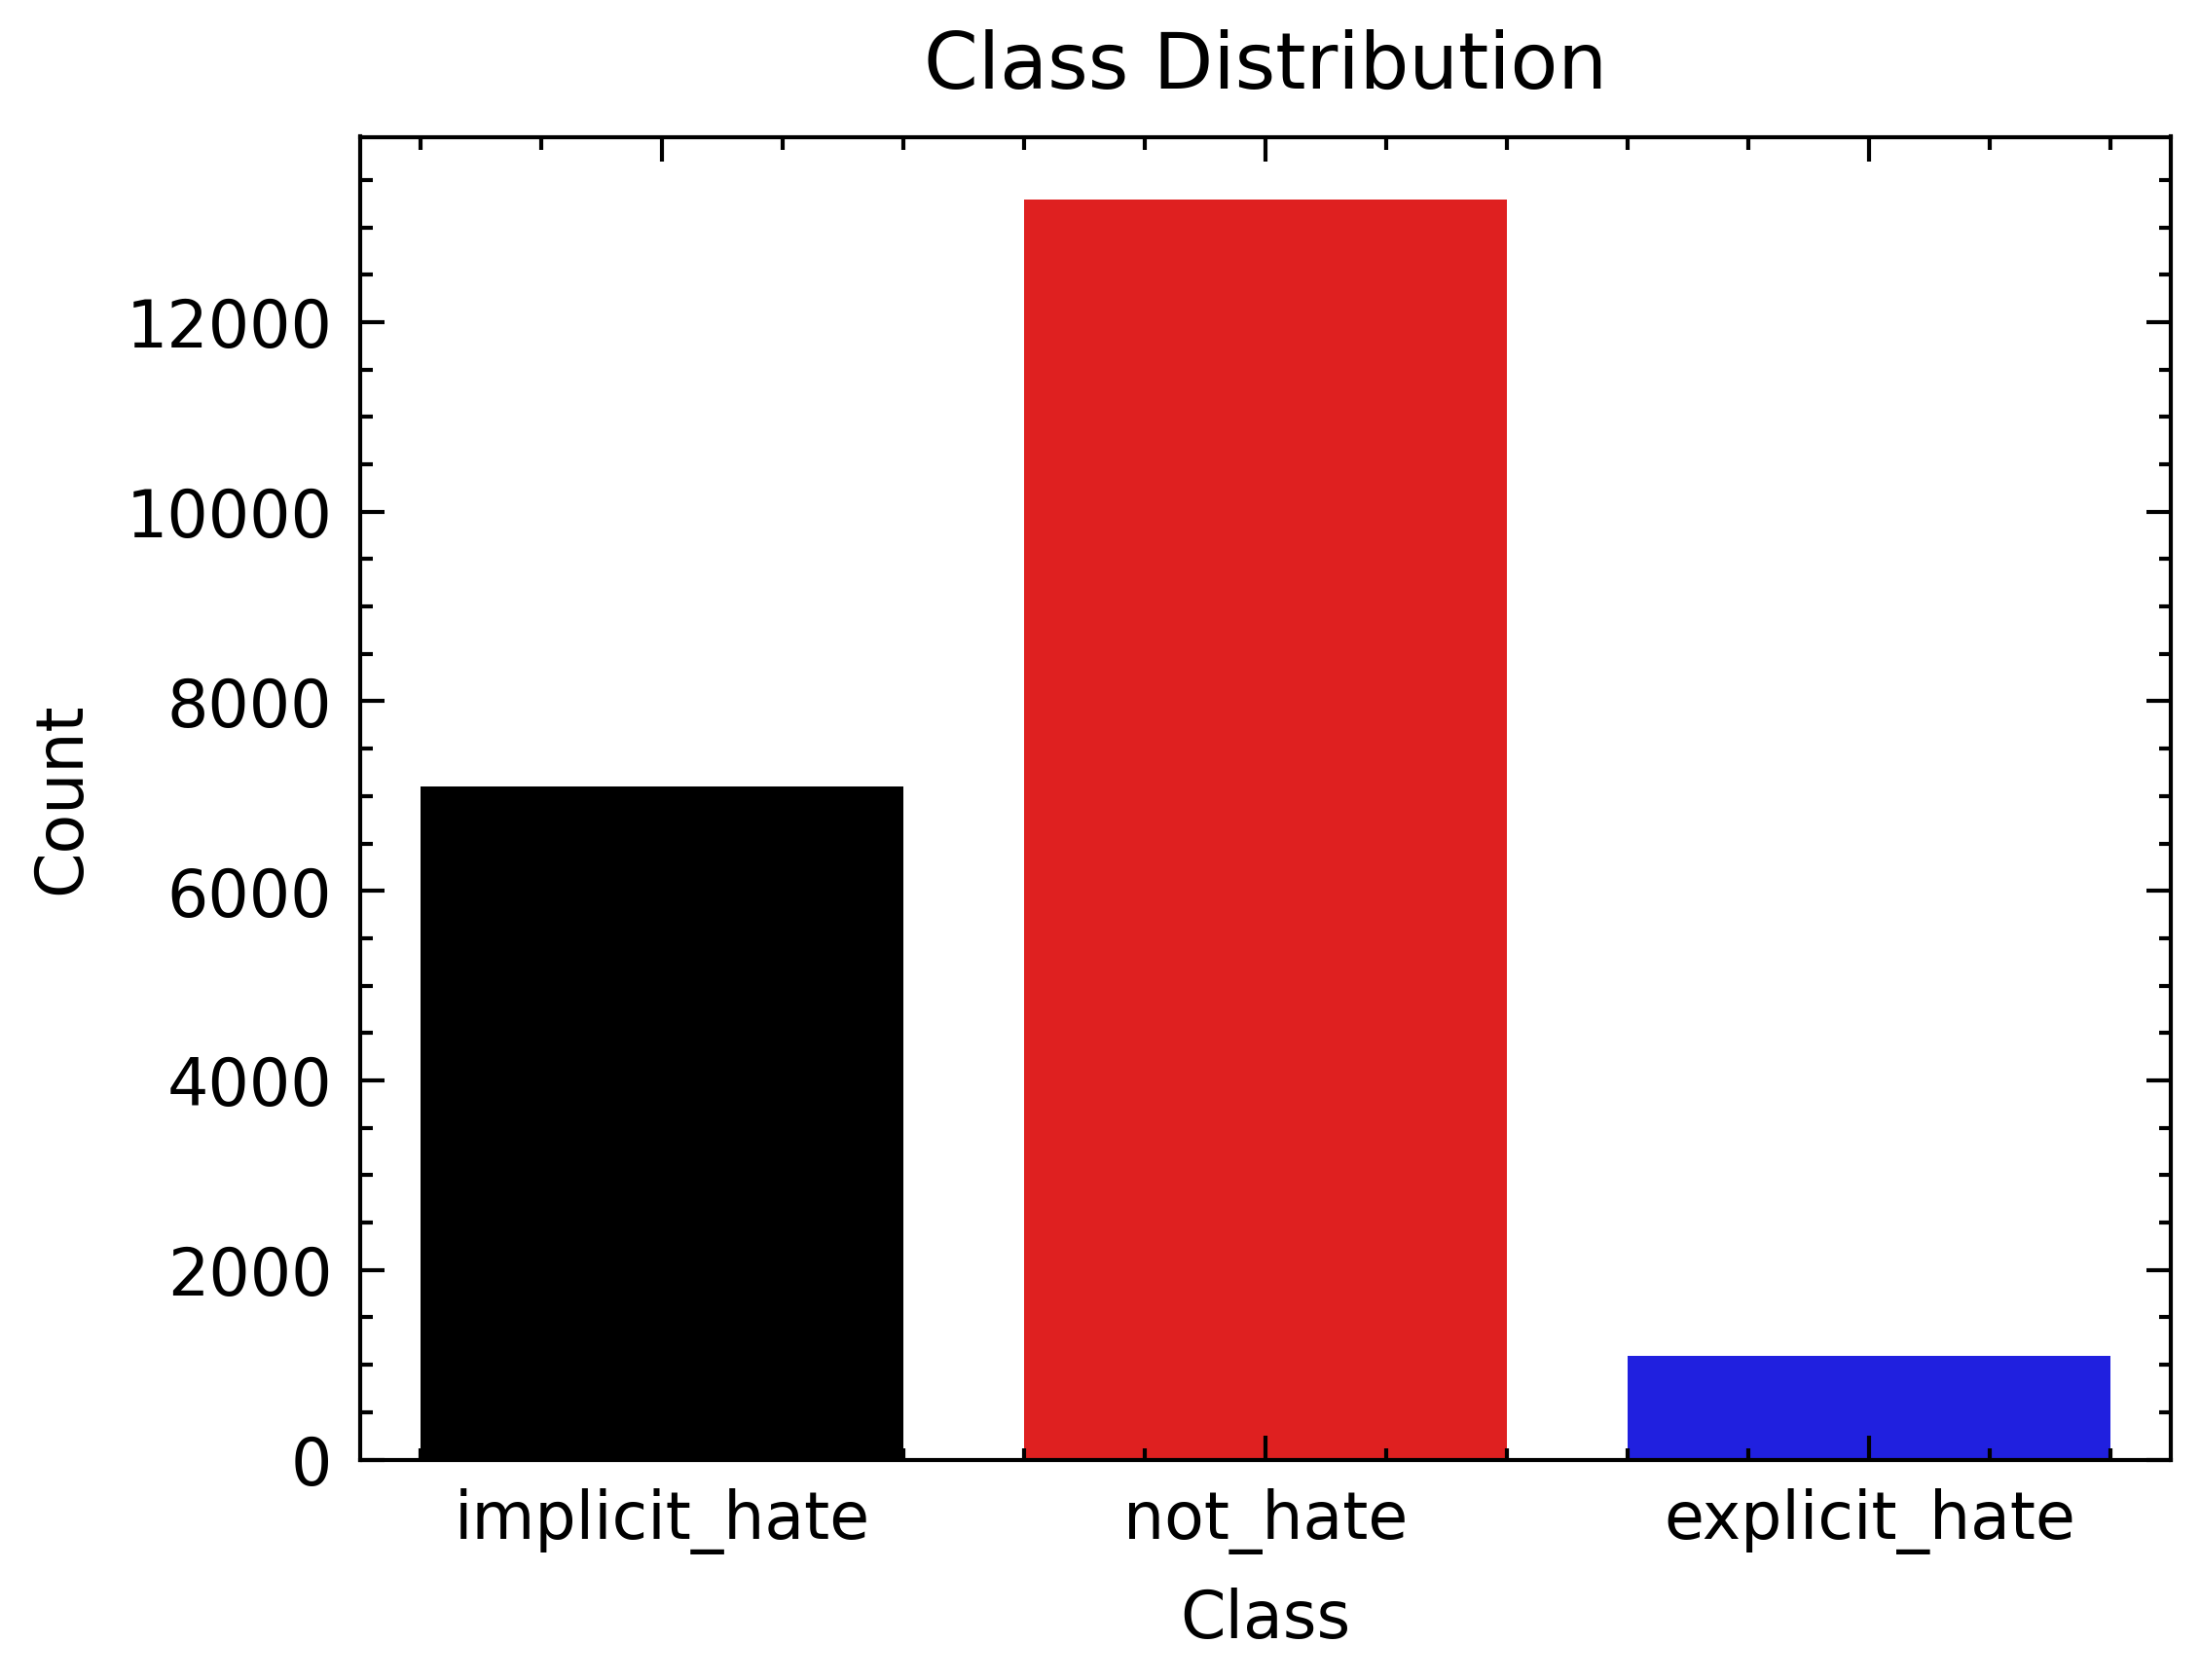

In [ ]:
fig, ax = plt.subplots(figsize=(4, 3))
sns.countplot(x=df["class"], ax=ax)
ax.set_ylabel("Count")
ax.set_xlabel("Class")
ax.set_title("Class Distribution")

In [ ]:
df["post_length"] = df["post"].map(len)

Text(0.5, 1.0, 'Distribution of Post Length (Characters)')

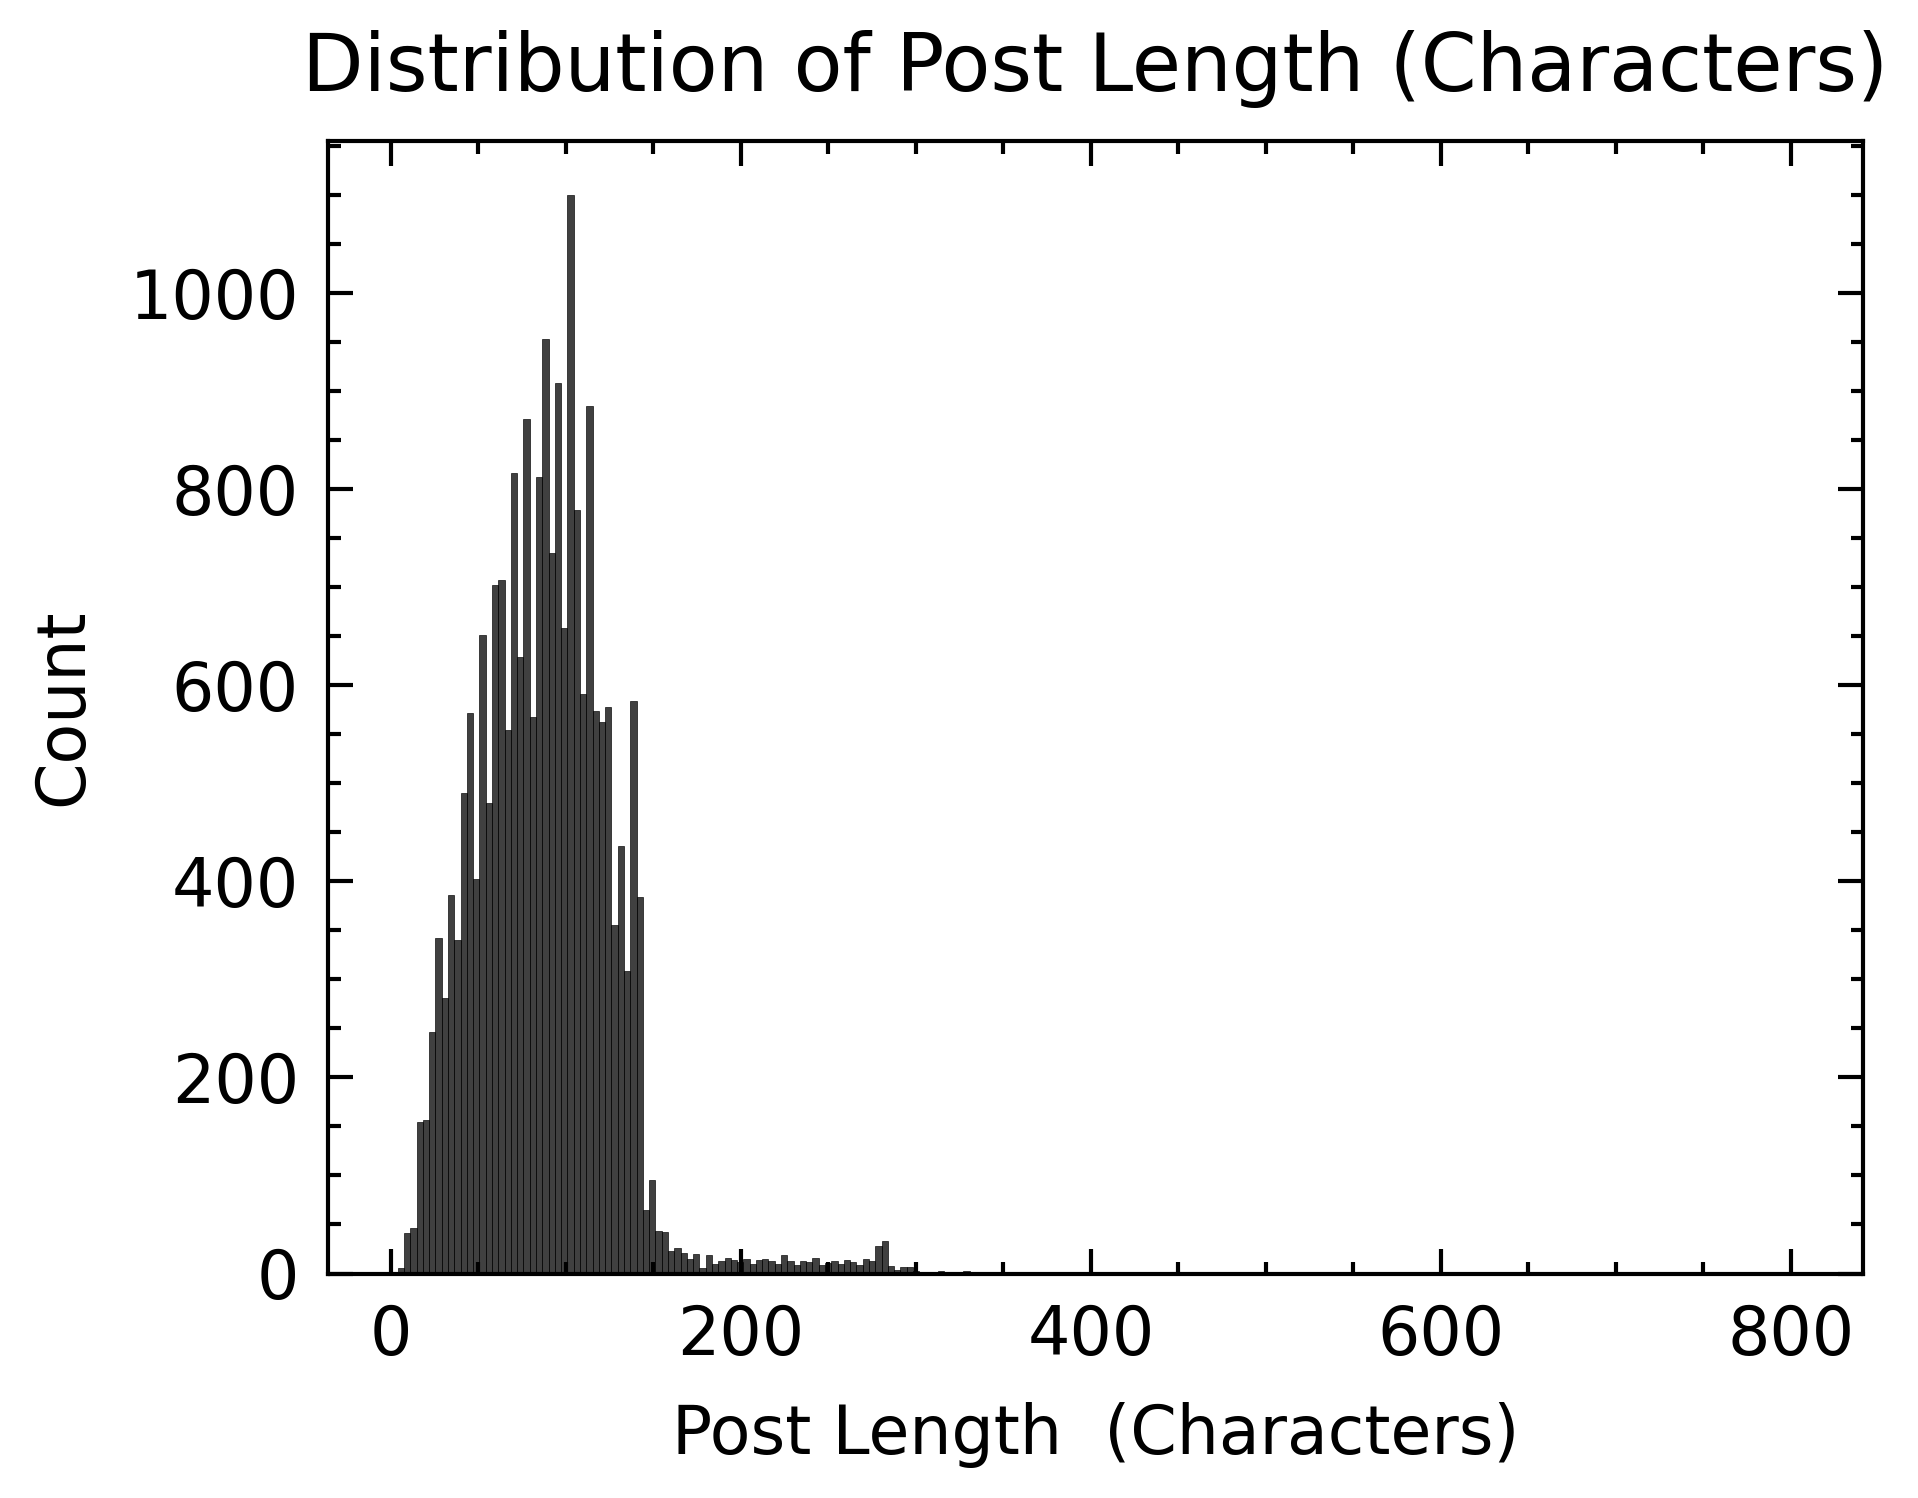

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df["post_length"])
ax.set_xlabel("Post Length  (Characters)")
ax.set_title("Distribution of Post Length (Characters)")

Text(0.5, 1.0, 'Distribution of Post Length (Characters)')

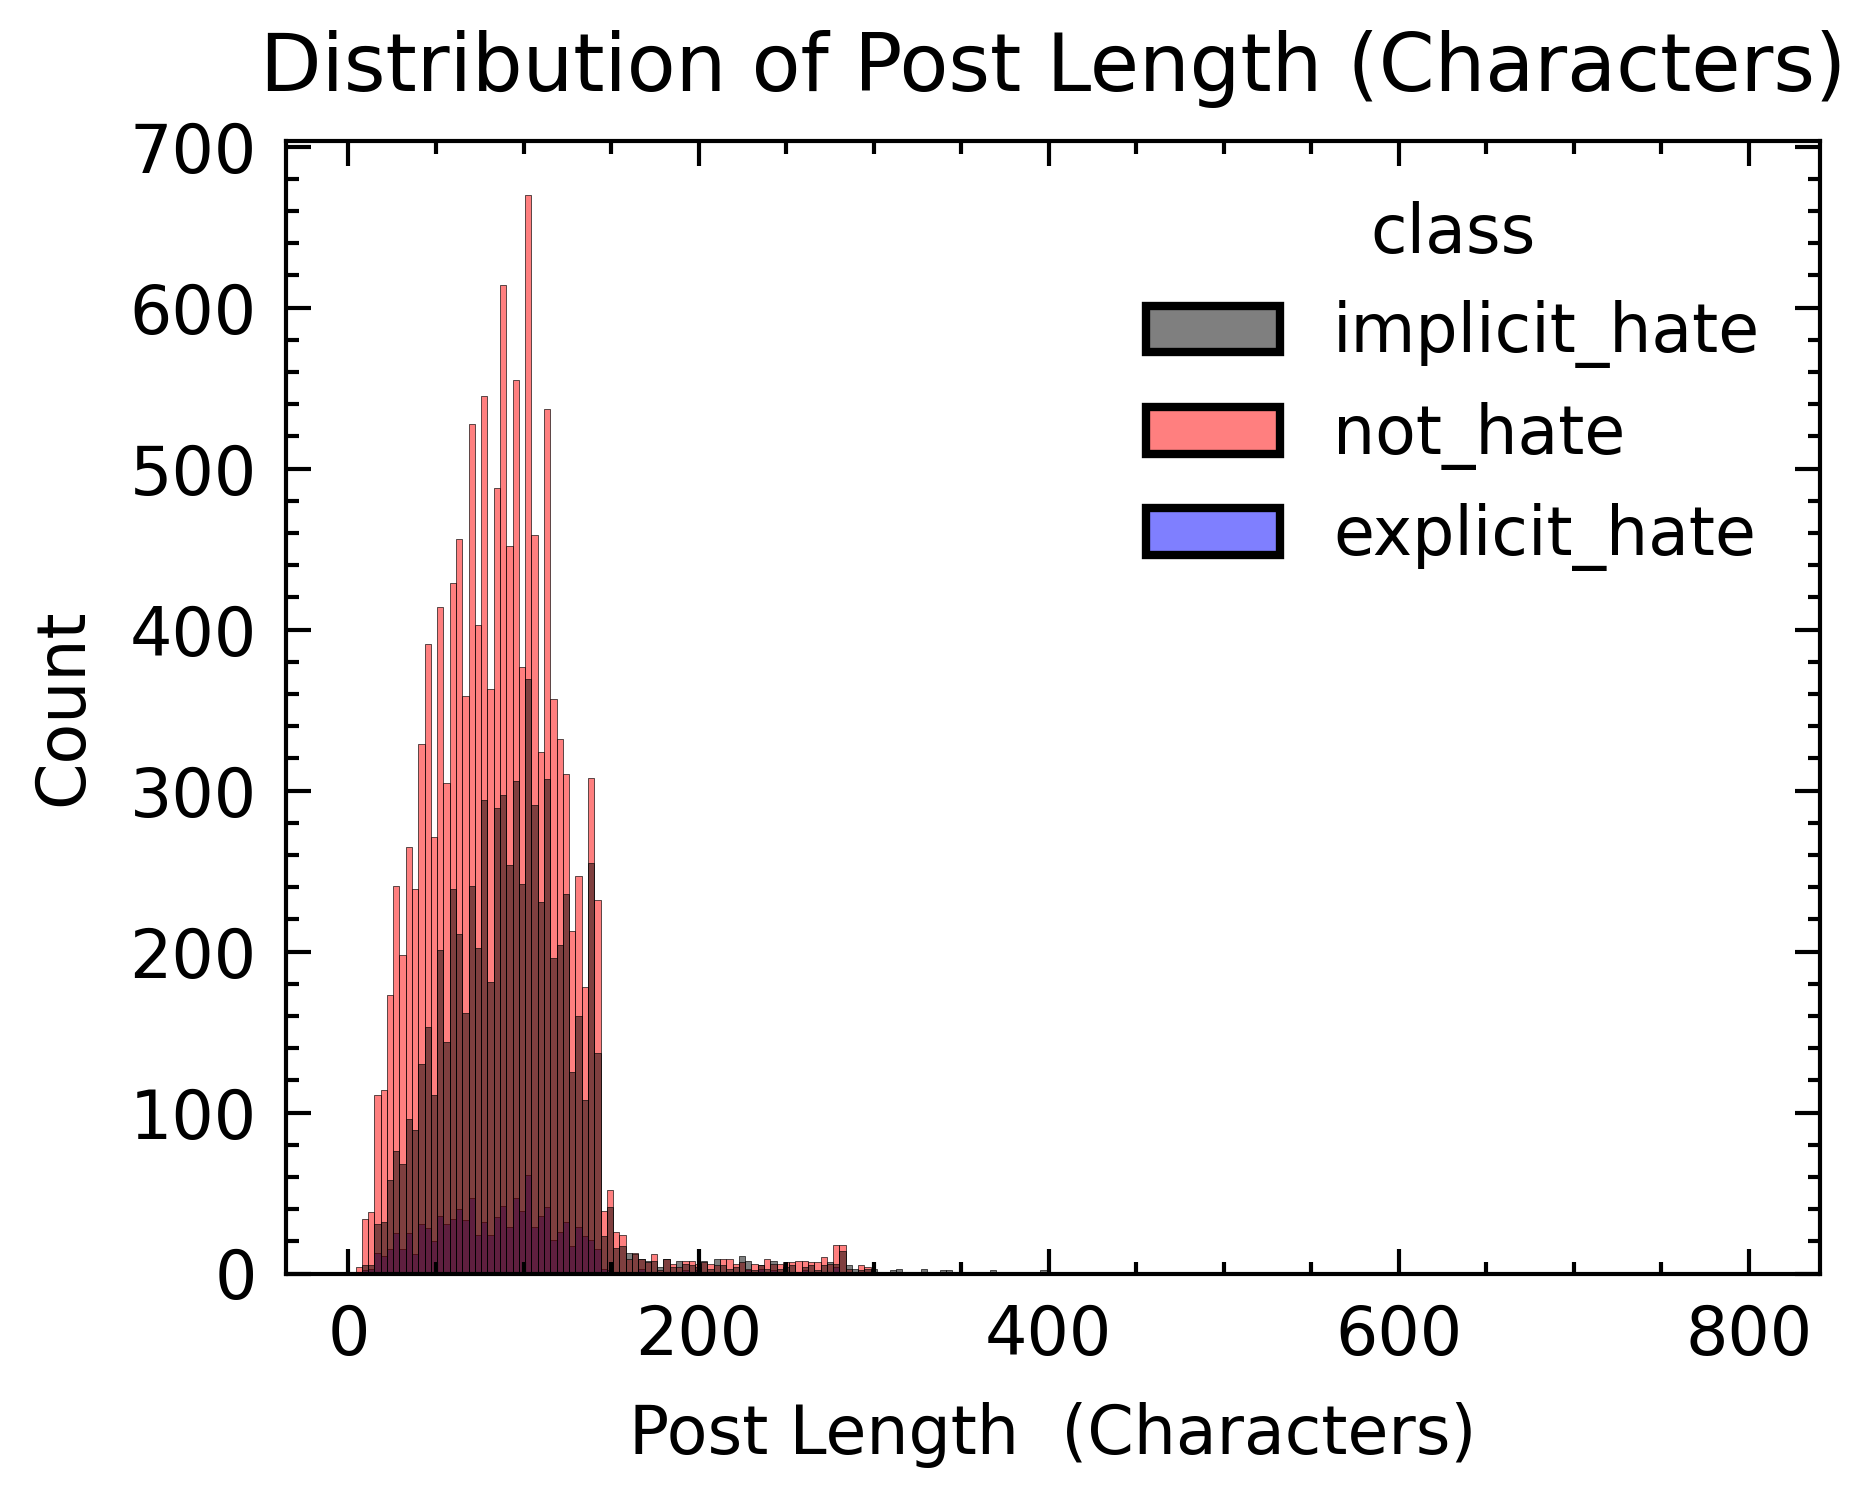

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df, x="post_length", hue="class")
ax.set_xlabel("Post Length  (Characters)")
ax.set_title("Distribution of Post Length (Characters)")

In [ ]:
df["post_length_words"] = df["post"].map(lambda x : len(x.split()))

Text(0.5, 1.0, 'Distribution of Post Length (Words)')

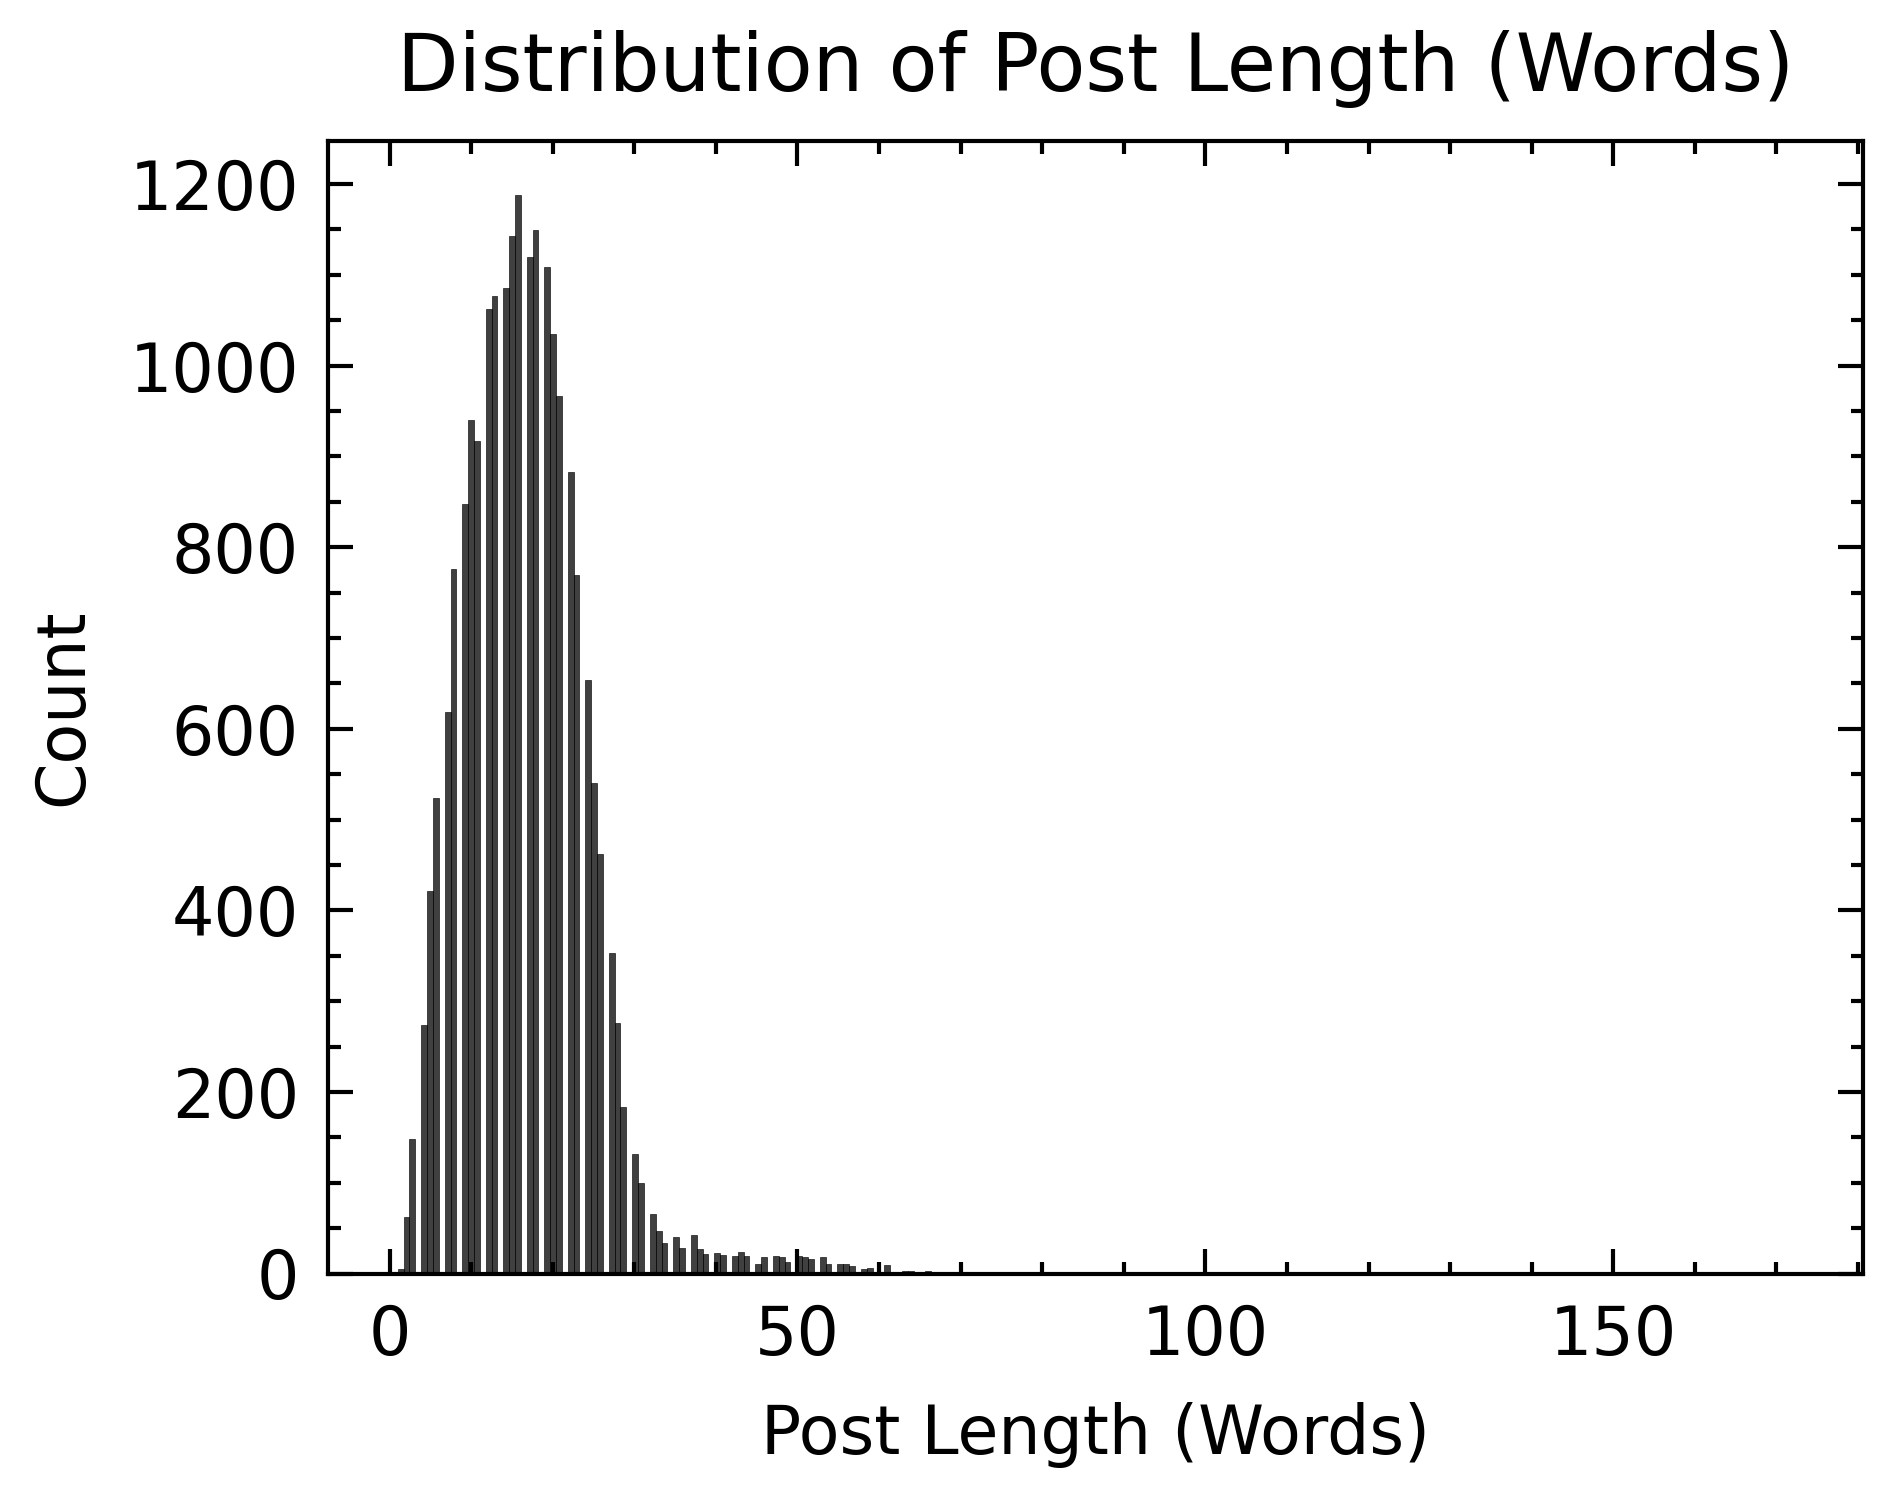

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df["post_length_words"])
ax.set_xlabel("Post Length (Words)")
ax.set_title("Distribution of Post Length (Words)")

Text(0.5, 1.0, 'Distribution of Post Length (Words)')

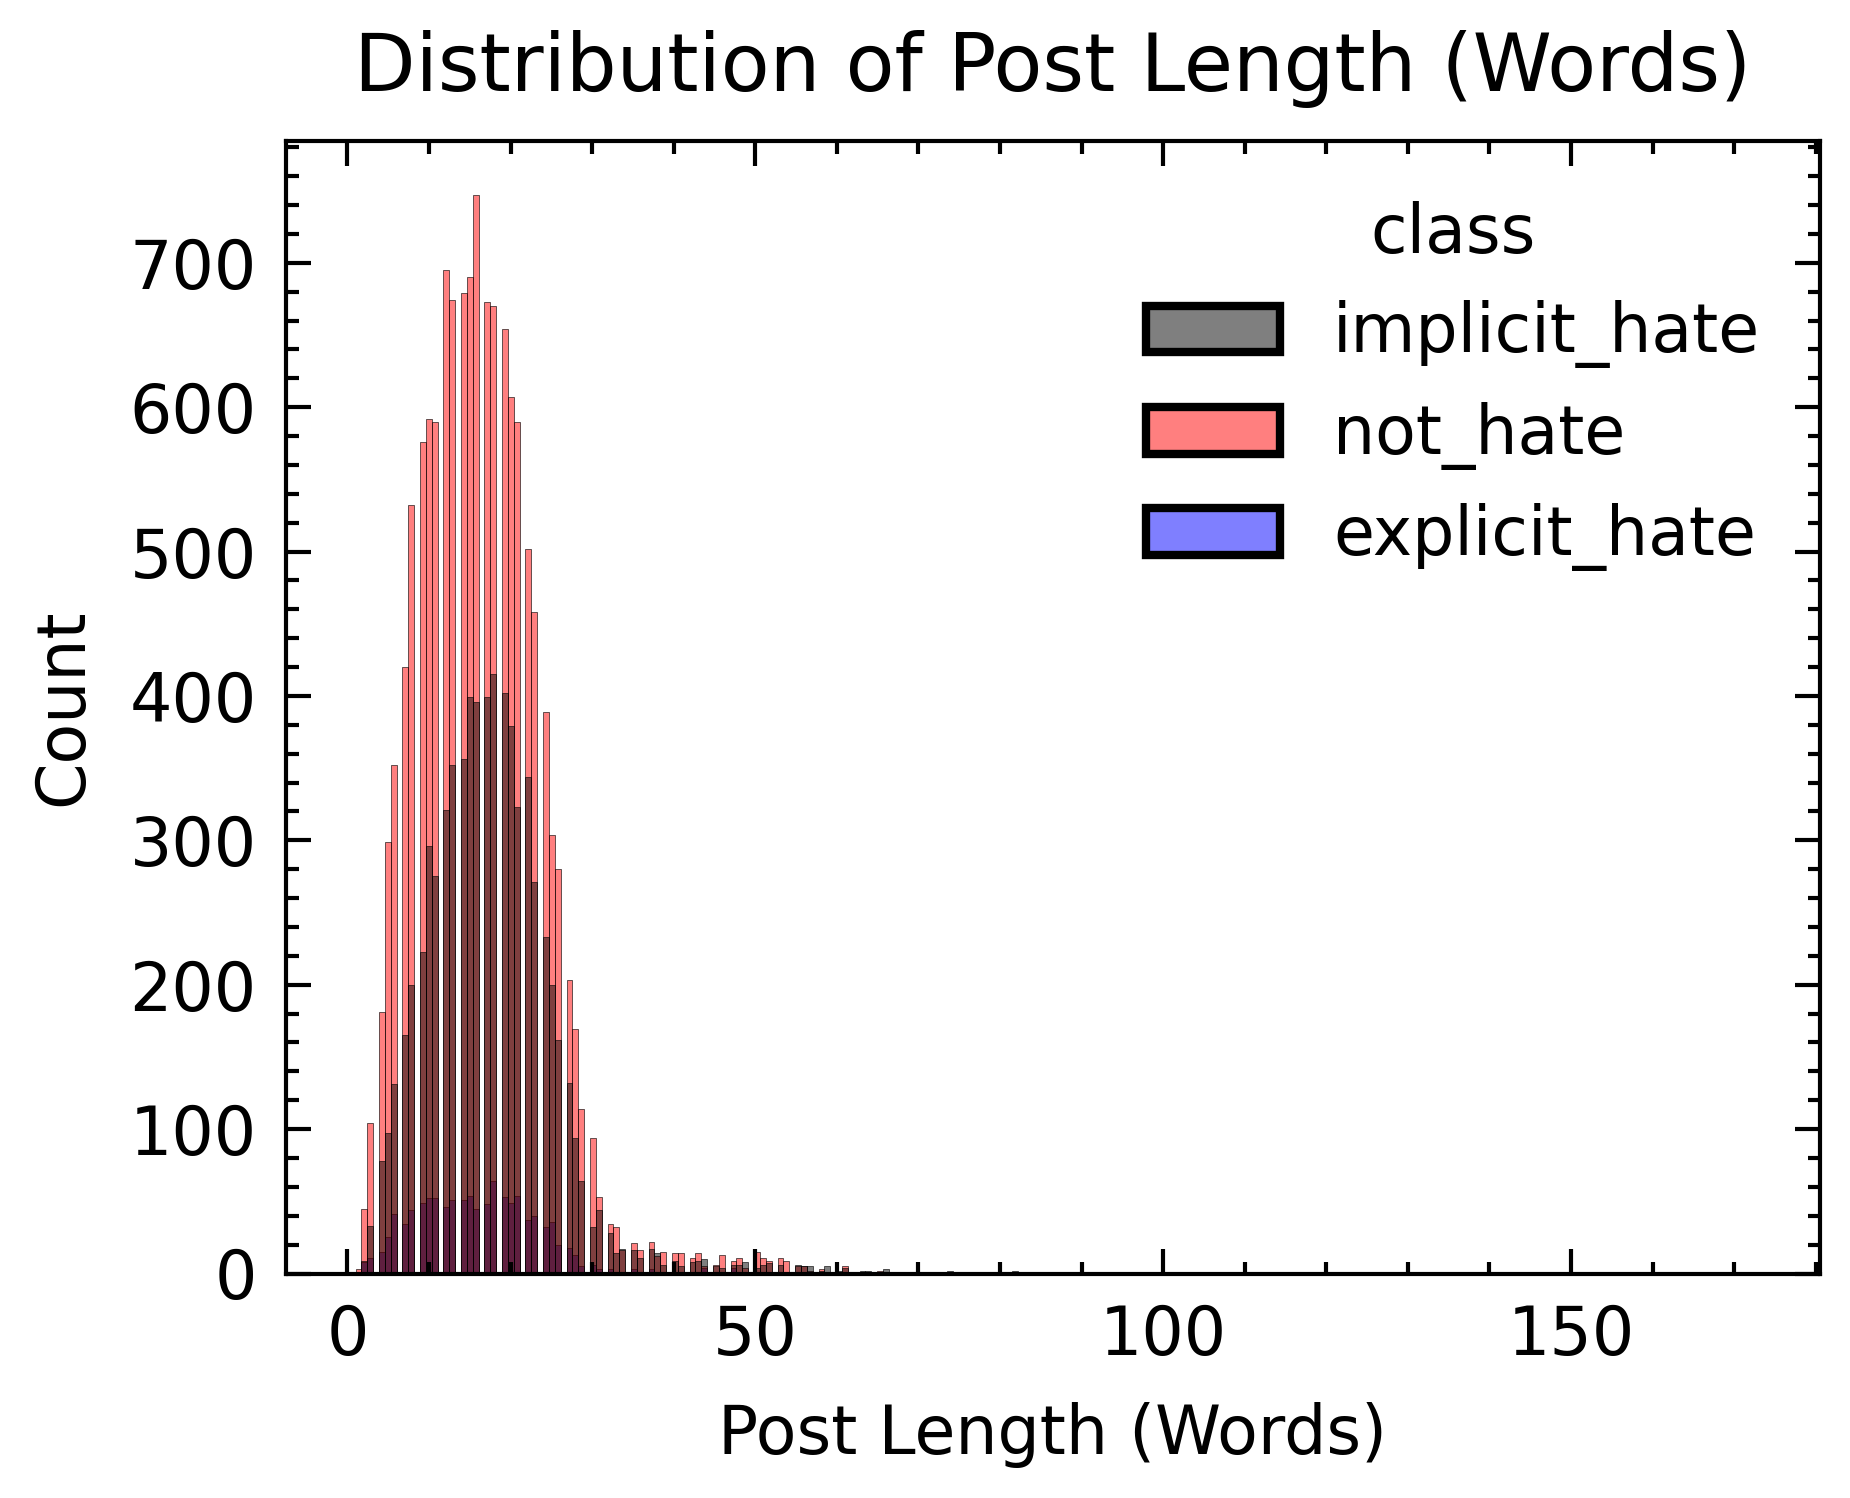

In [ ]:
fig, ax = plt.subplots()
sns.histplot(df, x="post_length_words", hue="class")
ax.set_xlabel("Post Length (Words)")
ax.set_title("Distribution of Post Length (Words)")

In [ ]:
word_vectorizer = CountVectorizer(
    ngram_range=(1, 3), analyzer='word', strip_accents = 'unicode', stop_words='english'
)
sparse_matrix = word_vectorizer.fit_transform(df['post'])
frequencies = sum(sparse_matrix).toarray()[0]
df_ngrams = pd.DataFrame(frequencies, index=word_vectorizer.get_feature_names(), columns=['frequency'])

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


Text(0, 0.5, 'n-Gram')

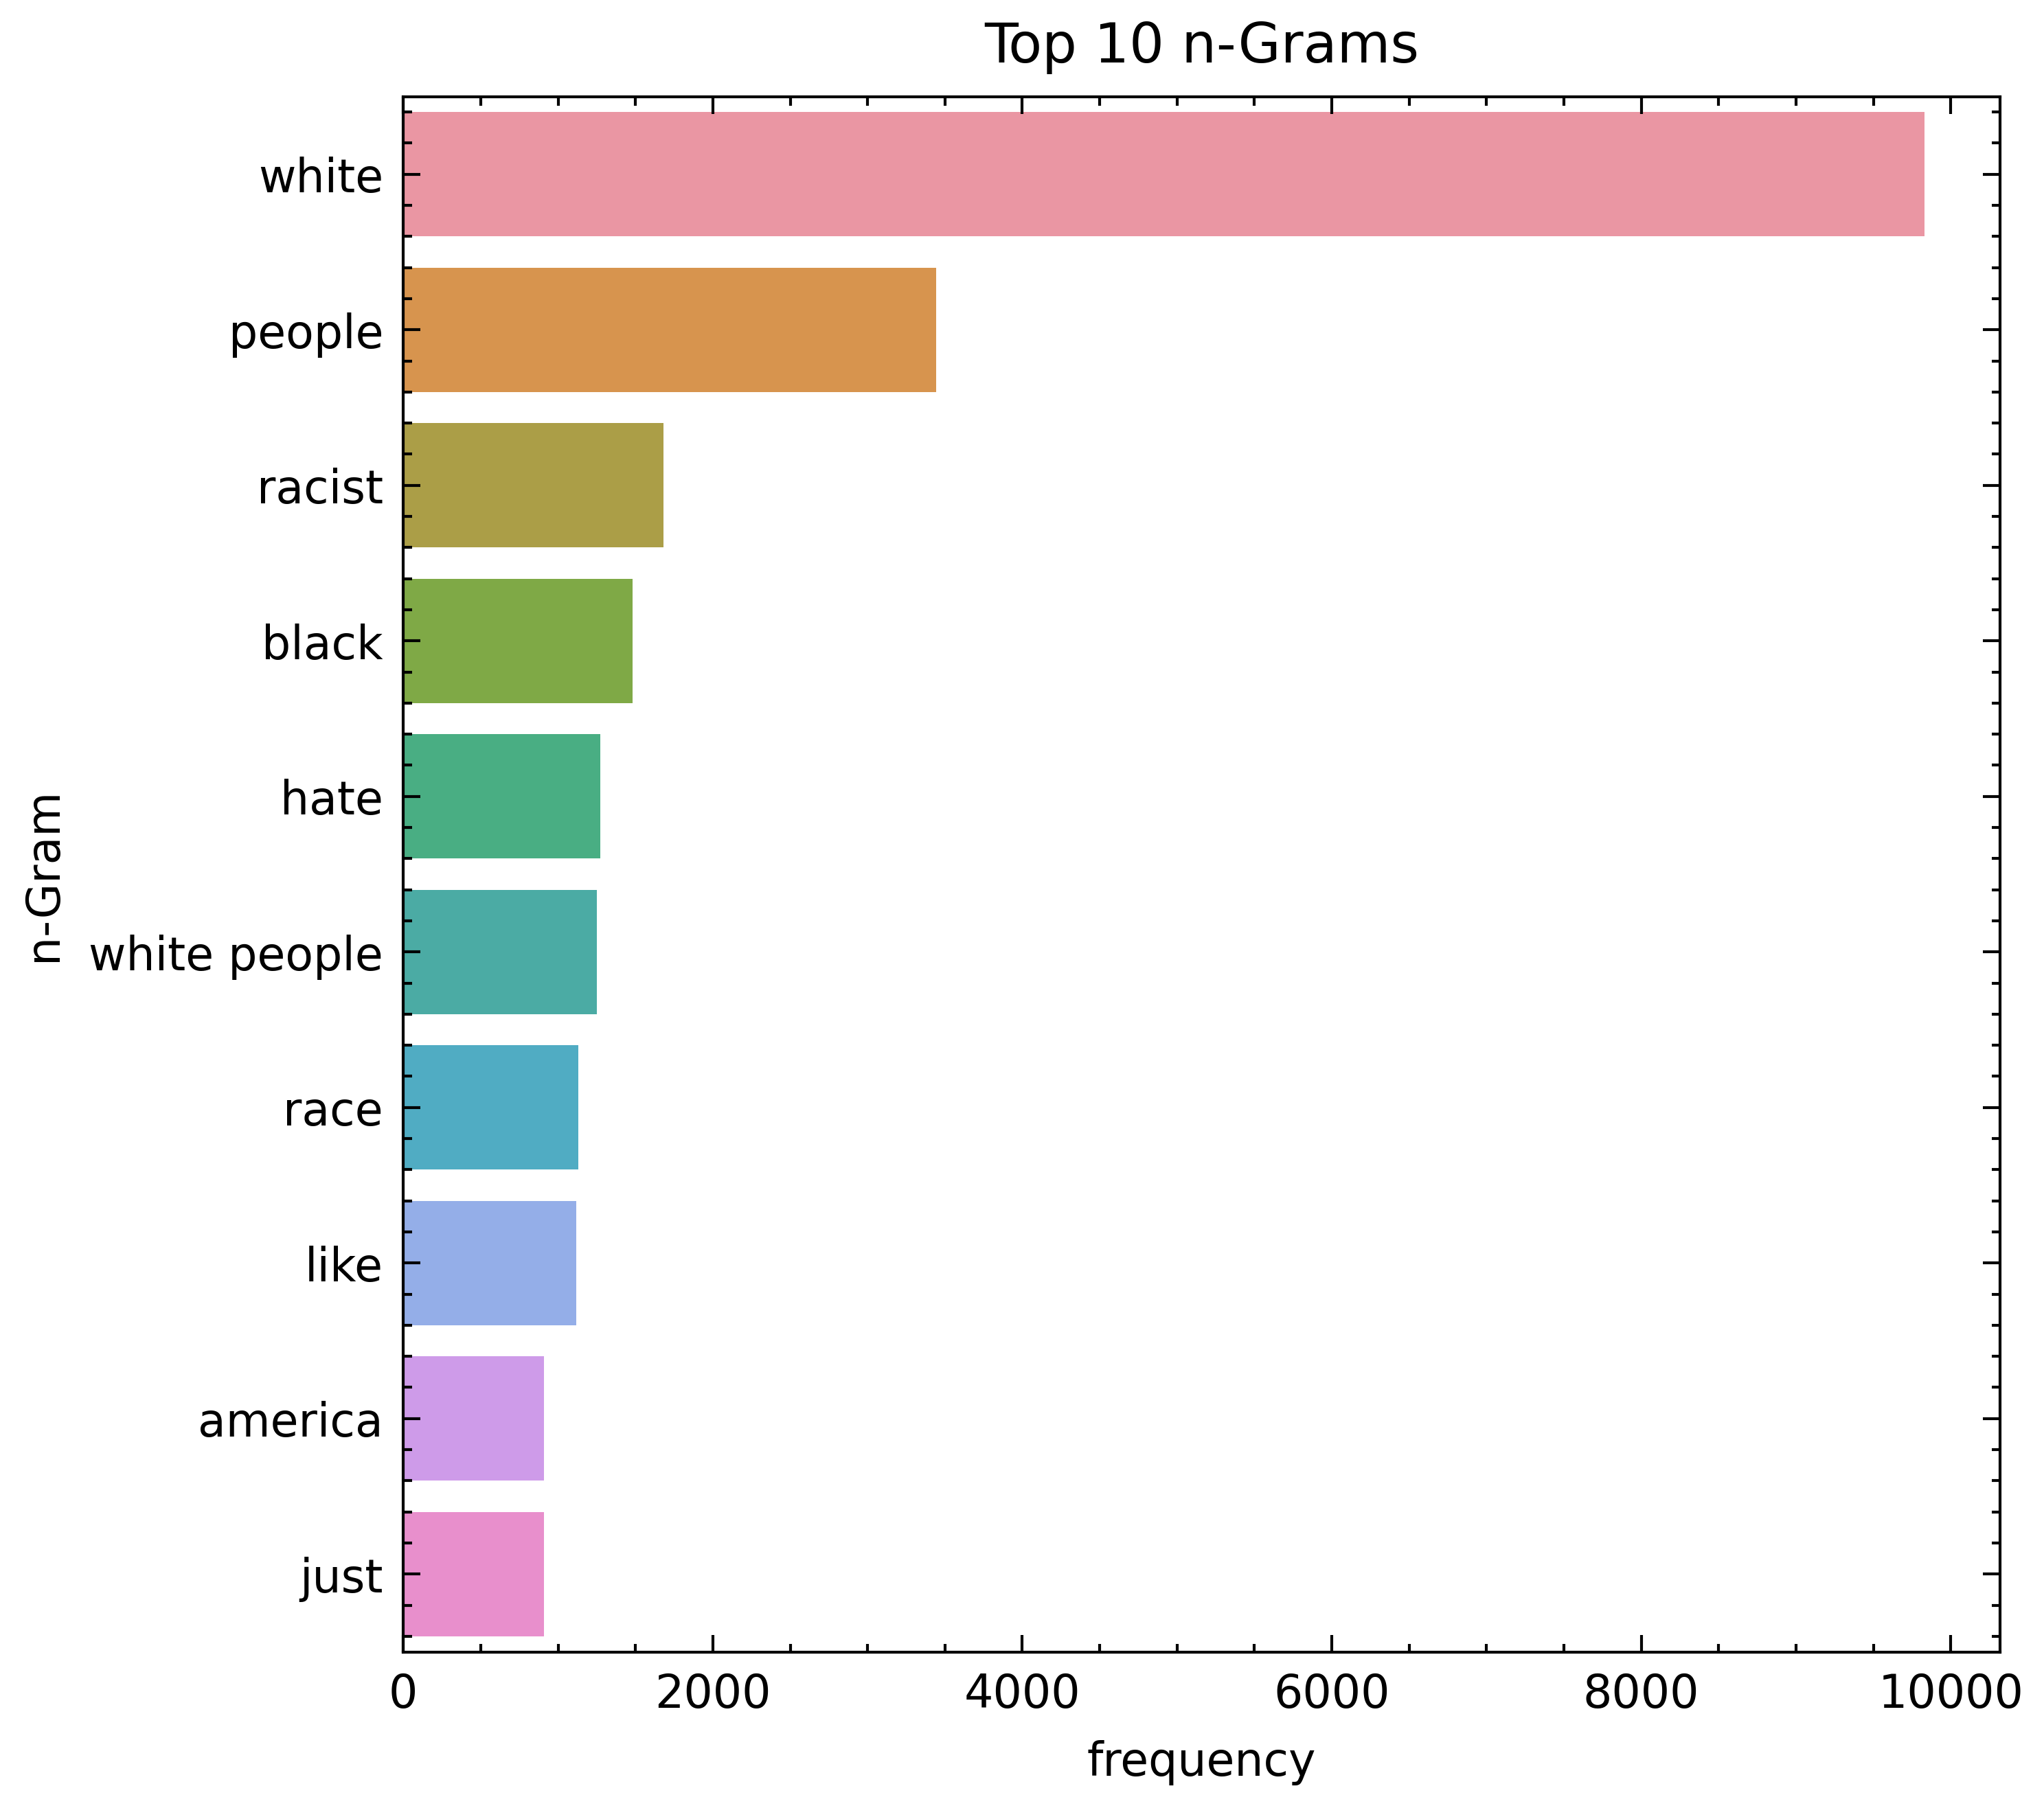

In [ ]:
top_10_ngrams = df_ngrams.sort_values('frequency', ascending=False).head(10)
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(y=top_10_ngrams.index, x=top_10_ngrams['frequency'])
ax.set_title("Top 10 n-Grams")
ax.set_ylabel("n-Gram")

# Data Preprocessing

In [14]:
max_seqlen = df["post"].apply(lambda x : len(x.split())).max()
max_seqlen

172

In [15]:
dataset_len = len(df)
dataset_len

21480

As in the initial benchmark set, we split our data 60-20-20

In [12]:
!pip install pyspellchecker

     |████████████████████████████████| 2.7 MB 5.0 MB/s 


In [16]:
from spellchecker import SpellChecker
spell = SpellChecker()
def spell_check(text):
  return ' '.join([
                   spell.correction(word) for word in text.split(" ")
  ])

In [17]:
df["spellchecked_post"] = df["post"].map(spell_check)

In [19]:
df.to_csv("/content/drive/MyDrive/Data/DELE CA1/Technical Paper/spell.tsv", sep="\t", index=False)

In [18]:
df

,post,class,spellchecked_post
0,""" : jewish harvard professor noel ignatiev w...",implicit_hate,"i i "" : jewish harvard professor noel ignatius..."
1,b.higher education is a part of european cult...,not_hate,i higher education is a part of european cultu...
2,"has a problem with "" the whites "" "" and "" "" ...",not_hate,"i has a problem with i "" the whites "" "" and "" ..."
3,is yasir qadhi a hate preacher for calling ch...,not_hate,i is yasir qadi a hate preacher for calling ch...
4,"rt "" : how three million germans mass murder...",not_hate,"i it i "" : how three million germans mass murd..."
...,...,...,...
21475,"Seeing prostitutes is morally wrong, but being...",implicit_hate,Seeing prostitutes is morally wrong but being ...
21476,I wonder how many females I raped today I spen...,implicit_hate,I wonder how many females I raped today I spen...
21477,Having a criminal record is more attractive to...,implicit_hate,Having a criminal record is more attractive to...
21478,Another advantage of being a female: getting b...,implicit_hate,Another advantage of being a female getting by...


In [16]:
df_bin = df[df["class"] != "explicit_hate"]
X, y = df_bin["spellchecked_post"], (df_bin["class"] == "implicit_hate").astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.4, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, random_state=42, test_size=0.5, stratify=y_test)
# le = LabelEncoder().fit(y_train)
# y_train = le.transform(y_train)
# y_val = le.transform(y_val)
# y_test = le.transform(y_test)
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE) #.map(to_ohe)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(BATCH_SIZE) #.map(to_ohe)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE) #.map(to_ohe)

In [10]:
print(y_train)

11083    0
16122    0
18169    0
13633    0
20460    1
        ..
3216     0
5295     0
20389    1
7894     0
8016     1
Name: class, Length: 12234, dtype: int64


In [11]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

12234
4078
4079


In [14]:
class F1Binary(Metric):
  def __init__(self, name='f1', beta=1, threshold=0.5, epsilon=1e-7, **kwargs):
    # initializing an object of the super class
    super(F1Binary, self).__init__(name=name, **kwargs)

    # initializing state variables
    self.tp = self.add_weight(name='tp', initializer='zeros') # initializing true positives 
    self.actual_positive = self.add_weight(name='fp', initializer='zeros') # initializing actual positives
    self.predicted_positive = self.add_weight(name='fn', initializer='zeros') # initializing predicted positives

    # initializing other atrributes that wouldn't be changed for every object of this class
    self.beta_squared = beta**2 
    self.threshold = threshold
    self.epsilon = epsilon

  def update_state(self, ytrue, ypred, sample_weight=None):
    # casting ytrue and ypred as float dtype
    ytrue = tf.cast(ytrue, tf.float32)
    ypred = tf.cast(ypred, tf.float32)

    # setting values of ypred greater than the set threshold to 1 while those lesser to 0
    ypred = tf.cast(tf.greater_equal(ypred, tf.constant(self.threshold)), tf.float32)
        
    self.tp.assign_add(tf.reduce_sum(ytrue*ypred)) # updating true positives atrribute
    self.predicted_positive.assign_add(tf.reduce_sum(ypred)) # updating predicted positive atrribute
    self.actual_positive.assign_add(tf.reduce_sum(ytrue)) # updating actual positive atrribute

  def result(self):
    self.precision = self.tp/(self.predicted_positive+self.epsilon) # calculates precision
    self.recall = self.tp/(self.actual_positive+self.epsilon) # calculates recall

    # calculating fbeta
    self.fb = (1+self.beta_squared)*self.precision*self.recall / (self.beta_squared*self.precision + self.recall + self.epsilon)
    
    return self.fb

  def reset_state(self):
    self.tp.assign(0) # resets true positives to zero
    self.predicted_positive.assign(0) # resets predicted positives to zero
    self.actual_positive.assign(0) # resets actual positives to zero

### Baseline: TF-IDF with SVM

In [120]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC
from sklearn.metrics import f1_score, accuracy_score, precision_score, recall_score
from sklearn.model_selection import RandomizedSearchCV

In [25]:

run = wandb.init(project="dele_ca1_paper",     config = {
        "architecture" : "Spellcheck TFIDF + Linear SVM",
        "dataset" : "Implicit Hate V1 STG 1"
    })


wandb: Currently logged in as: tiencheng (use `wandb login --relogin` to force relogin)


In [36]:
tfidf = TfidfVectorizer(stop_words="english")

pipe = make_pipeline(tfidf, SVC(kernel="linear", C=1,probability=True))

# pipe.fit(X_train, y_train)

In [35]:
X_train

11083    you are just a modern day version of those hat...
16122    i'm not talking as bop worker and i am with mo...
18169    so why are libs afraid of securing our borders...
13633    the art is a conduit upon which alt right imag...
20460    end daca deport all they can come back the leg...
                               ...                        
3216     he's not a white supremacist and that guy you'...
5295     probably chan i the other 3 can still be dismi...
20389    we kill we go to jail they slaughter us and ge...
7894     isn't he a civil rights icon . ? ? ? and appar...
8016     not referring to a single tattoo . perhaps it'...
Name: spellchecked_post, Length: 12234, dtype: object

In [37]:
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)

In [28]:
params = {
    "C" : [0.1, 1, 10, 100, 100],
    "kernel" : ["linear", "rbf"]
}

rs = RandomizedSearchCV(SVC(), params, n_iter=50, scoring='f1', n_jobs=-1, return_train_score=True)

In [ ]:
rs.fit(X_train_tfidf, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_search.py:296: UserWarning: The total space of parameters 10 is smaller than n_iter=50. Running 10 iterations. For exhaustive searches, use GridSearchCV.
  UserWarning,


RandomizedSearchCV(estimator=SVC(), n_iter=50, n_jobs=-1,
                   param_distributions={'C': [0.1, 1, 10, 100, 100],
                                        'kernel': ['linear', 'rbf']},
                   return_train_score=True, scoring='f1')

In [ ]:
rs.best_params_

{'C': 1, 'kernel': 'linear'}

In [ ]:
rs.best_score_

0.5246279644295369

In [38]:
pipe.fit(X_train, y_train)

Pipeline(steps=[('tfidfvectorizer', TfidfVectorizer(stop_words='english')),
                ('svc', SVC(C=1, kernel='linear', probability=True))])

In [30]:
val_preds = pipe.predict(X_val)
y_probas = pipe.predict_proba(X_val)
acc = accuracy_score(y_val, val_preds)
f1 = f1_score(y_val, val_preds)
precision = precision_score(y_val, val_preds)
recall = recall_score(y_val, val_preds)
# Visualize all classifier plots
wandb.sklearn.plot_classifier(pipe, X_train, X_val, y_train, y_val, val_preds, y_probas, ['Not Hate', 'Implicit Hate'],
                                                         model_name='SVC')



wandb: 
wandb: Plotting SVC.
wandb: ERROR Please fit the model before passing it in.
wandb: Logged feature importances.
wandb: Logged confusion matrix.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR X_test contains values that are not numbers. Please vectorize, label encode or one hot encode X_test and call the plotting function again.
wandb: ERROR Please fit the model before passing it in.
wandb: Logged summary metrics.
wandb: Logged class proportions.
wandb: ERROR X contains values that are not numbers. Please vectorize, label encode or one hot encode X and call the plotting function again.
wandb: ERROR Please fit the model before passing it in.
wandb: Logged calibration curve.
wandb: Logged roc curve.
wandb: Logged precision-recall curve.


In [31]:
print("Accuracy:", acc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7106424717999019
F1: 0.5187601957585644
Precision: 0.6162790697674418
Recall: 0.447887323943662


In [39]:
val_preds = pipe.predict(X_test)
# y_probas = pipe.predict_proba(X_test)
acc = accuracy_score(y_test, val_preds)
f1 = f1_score(y_test, val_preds)
precision = precision_score(y_test, val_preds)
recall = recall_score(y_test, val_preds)

In [40]:
print("Accuracy:", acc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7286099534199558
F1: 0.5450061652281134
Precision: 0.6544916090819348
Recall: 0.4669014084507042


In [ ]:
run.finish()

## Basic RNN

In [15]:
#@tf.keras.utils.register_keras_serializable() # Decorator to allow us to save the TextVectorizer layer
def text_preprocessor(text):
  text = tf.strings.regex_replace(text, '((www\.[^\s]+)|(https?://[^\s]+))', "link")
  punctuation = '!#"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'
  stopwords = {'whom', 'all', 'shouldn', 'wouldn', 'how', 's', 'they', 'were', 'mustn', 'after', 'who', 'its', 'our', 't', 'a', 'very', 'an', 'do', 'be', 'to', 'can', 'had', 'i', 'these', 'himself', 'up', 'just', 'them', 'now', 'has', 'too', 'below', 'did', 'shan', 'until', 'during', 'him', 'into', 'have', "you'd", 'haven', 'theirs', 'ourselves', 'once', "isn't", 'than', "it's", 'wasn', 'yours', "mightn't", 'here', 'ours', 'her', 'doing', 'd', 'yourself', 'y', 'before', 'does', 'then', 'between', 'some', 'with', "needn't", 'but', 'didn', "shouldn't", 'that', "weren't", 'which', 'or', "hasn't", 'own', 'about', 'what', "aren't", 'couldn', 'doesn', 'as', "wouldn't", 'hasn', 'no', 'm', 'hers', 'hadn', 'aren', 'while', 'will', "don't", "shan't", 'why', 'at', 'mightn', 'themselves', 'weren', "that'll", 'isn', 'only', 'the', 'been', "couldn't", 'don', 'should', 'same', 'both', 'where', 'was', 'me', 'through', "hadn't", 've', 'against', 'if', 'under', 'such', 'is', 'll', "haven't", 'ain', 're', "didn't", 'nor', 'not', 'being', 'are', 'your', 'over', 'off', 'having', 'by', "won't", 'myself', 'out', 'more', "wasn't", "doesn't", 'won', 'this', 'my', 'again', 'ma', 'his', 'when', 'you', 'there', 'herself', 'yourselves', 'itself', 'of', "she's", 'needn', 'we', "mustn't", 'above', "you're", 'so', 'it', "should've", 'am', 'he', 'those', 'further', 'she', 'down', 'on', "you'll", 'for', 'other', 'any', 'their', 'from', 'each', 'most', 'because', 'and', 'few', 'in', "you've", 'o'}
  text = tf.strings.regex_replace(text, '[%s]' % punctuation, "") # remove punctuation
  for stopword in stopwords:
    text = tf.strings.regex_replace(text, r"\b%s\b" % stopword, "") # remove stopwards
  text = tf.strings.lower(text)
  text = tf.strings.strip(text)  
  text = tf.strings.regex_replace(text, r'\s+', ' ') # replace multiple whitesace with just one
  return text

sample_text = X_train[123]
print(text_preprocessor(sample_text))

tf.Tensor(b'cincinnati police officer dubbed 40 blacks attacking 1 white person hate crime wrong', shape=(), dtype=string)


In [16]:
max_words = 1900000

In [17]:
def create_tokenizer(train_ds, max_words, max_seqlen, output_mode = "int", standardize = "lower_and_strip_punctuation"):
  train_text = train_ds.map(lambda x, y : x)
  tokenizer = tfl.TextVectorization(
      standardize=standardize,
      max_tokens=max_words,
      output_sequence_length=max_seqlen,
      output_mode=output_mode
  )
  tokenizer.adapt(train_text)
  return tokenizer

In [18]:
tokenizer = create_tokenizer(train_ds, max_words, max_seqlen, standardize=text_preprocessor)

In [19]:
def load_pretrained_embeddings_v1(embedding_file, embedding_dim, vocabulary, max_words, max_seqlen):
  embedding_vecs = dict()
  word_idx = dict(zip(vocabulary, range(len(vocabulary))))
  with open(embedding_file, "r") as f:
    for line in f:
      values = line.strip().split()
      word = values[0]
      embedding_vec = np.asarray(values[1:], dtype='float32')
      embedding_vecs[word] = embedding_vec
  embedding_matrix = np.zeros((max_words, embedding_dim))
  for word, idx in word_idx.items():
    if idx < max_words:
      embedding_vec = embedding_vecs.get(word)
      if embedding_vec is not None:
        embedding_matrix[idx] = embedding_vec
  embedding = tfl.Embedding(max_words, embedding_dim, embeddings_initializer=tf.keras.initializers.Constant(embedding_matrix), mask_zero=False, input_length=max_seqlen, trainable=False)
  return embedding

In [20]:
vocabulary = tokenizer.get_vocabulary()
embedding = load_pretrained_embeddings_v1("/content/drive/MyDrive/Data/DELE CA1/Technical Paper/Embeddings/glove.42B.300d.txt", 300, vocabulary=vocabulary, max_words=max_words, max_seqlen=max_seqlen)

In [21]:
def create_hatenet_v1(tokenizer, embedding_layer, max_words, max_seqlen):
    model = Sequential(
      [
      tokenizer,
      embedding_layer,
      tfl.Bidirectional(tfl.LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001), input_shape=(max_words, max_seqlen))),
      tfl.Bidirectional(tfl.LSTM(128, return_sequences=True,  kernel_regularizer=l2(0.001))),
      tfl.Bidirectional(tfl.LSTM(128, return_sequences=False, kernel_regularizer=l2(0.001))),
      tfl.Dense(50, activation='relu', kernel_regularizer=l2(0.001)),
      tfl.Dropout(0.2),
      tfl.Dense(1, activation='sigmoid', kernel_regularizer=l2(0.001))
      ]
    )
    return model

In [22]:
run = wandb.init(
    project='dele_ca1_paper',
    config = {
        "learning_rate" : 0.01,
        "epochs" : 20,
        "batch_size" : 64,
        "loss_function" : "binary_crossentropy",
        "architecture" : "BiLSTM 3 Layers + 50 Unit Dense 300 dim Common Crawl 42B tokens Class Weight Spellcheck",
        "dataset" : "Implicit Hate V1 STG 1",
        "preprocessing": "remove-stop-words"
    }
)
config = wandb.config


wandb: Currently logged in as: tiencheng (use `wandb login --relogin` to force relogin)


In [23]:
from sklearn.utils import compute_class_weight
class_weights = compute_class_weight(
    "balanced", classes=np.unique(y_train), y=y_train
)
class_weights = dict(enumerate(class_weights))
print(class_weights)

{0: 0.7671181339352897, 1: 1.4359154929577465}


In [24]:
tf.keras.backend.clear_session()
model = create_hatenet_v1(tokenizer, embedding, max_words, max_seqlen)
print(model.summary())
optimizer = 'adam'
model.compile(optimizer, config.loss_function, metrics=['acc', F1Binary(), Precision(), Recall()])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization (TextVec  (None, 172)              0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 172, 300)          570000000 
                                                                 
 bidirectional (Bidirectiona  (None, 172, 256)         439296    
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 172, 256)         394240    
 nal)                                                            
                                                                 
 bidirectional_2 (Bidirectio  (None, 256)              394240    
 nal)                                                   

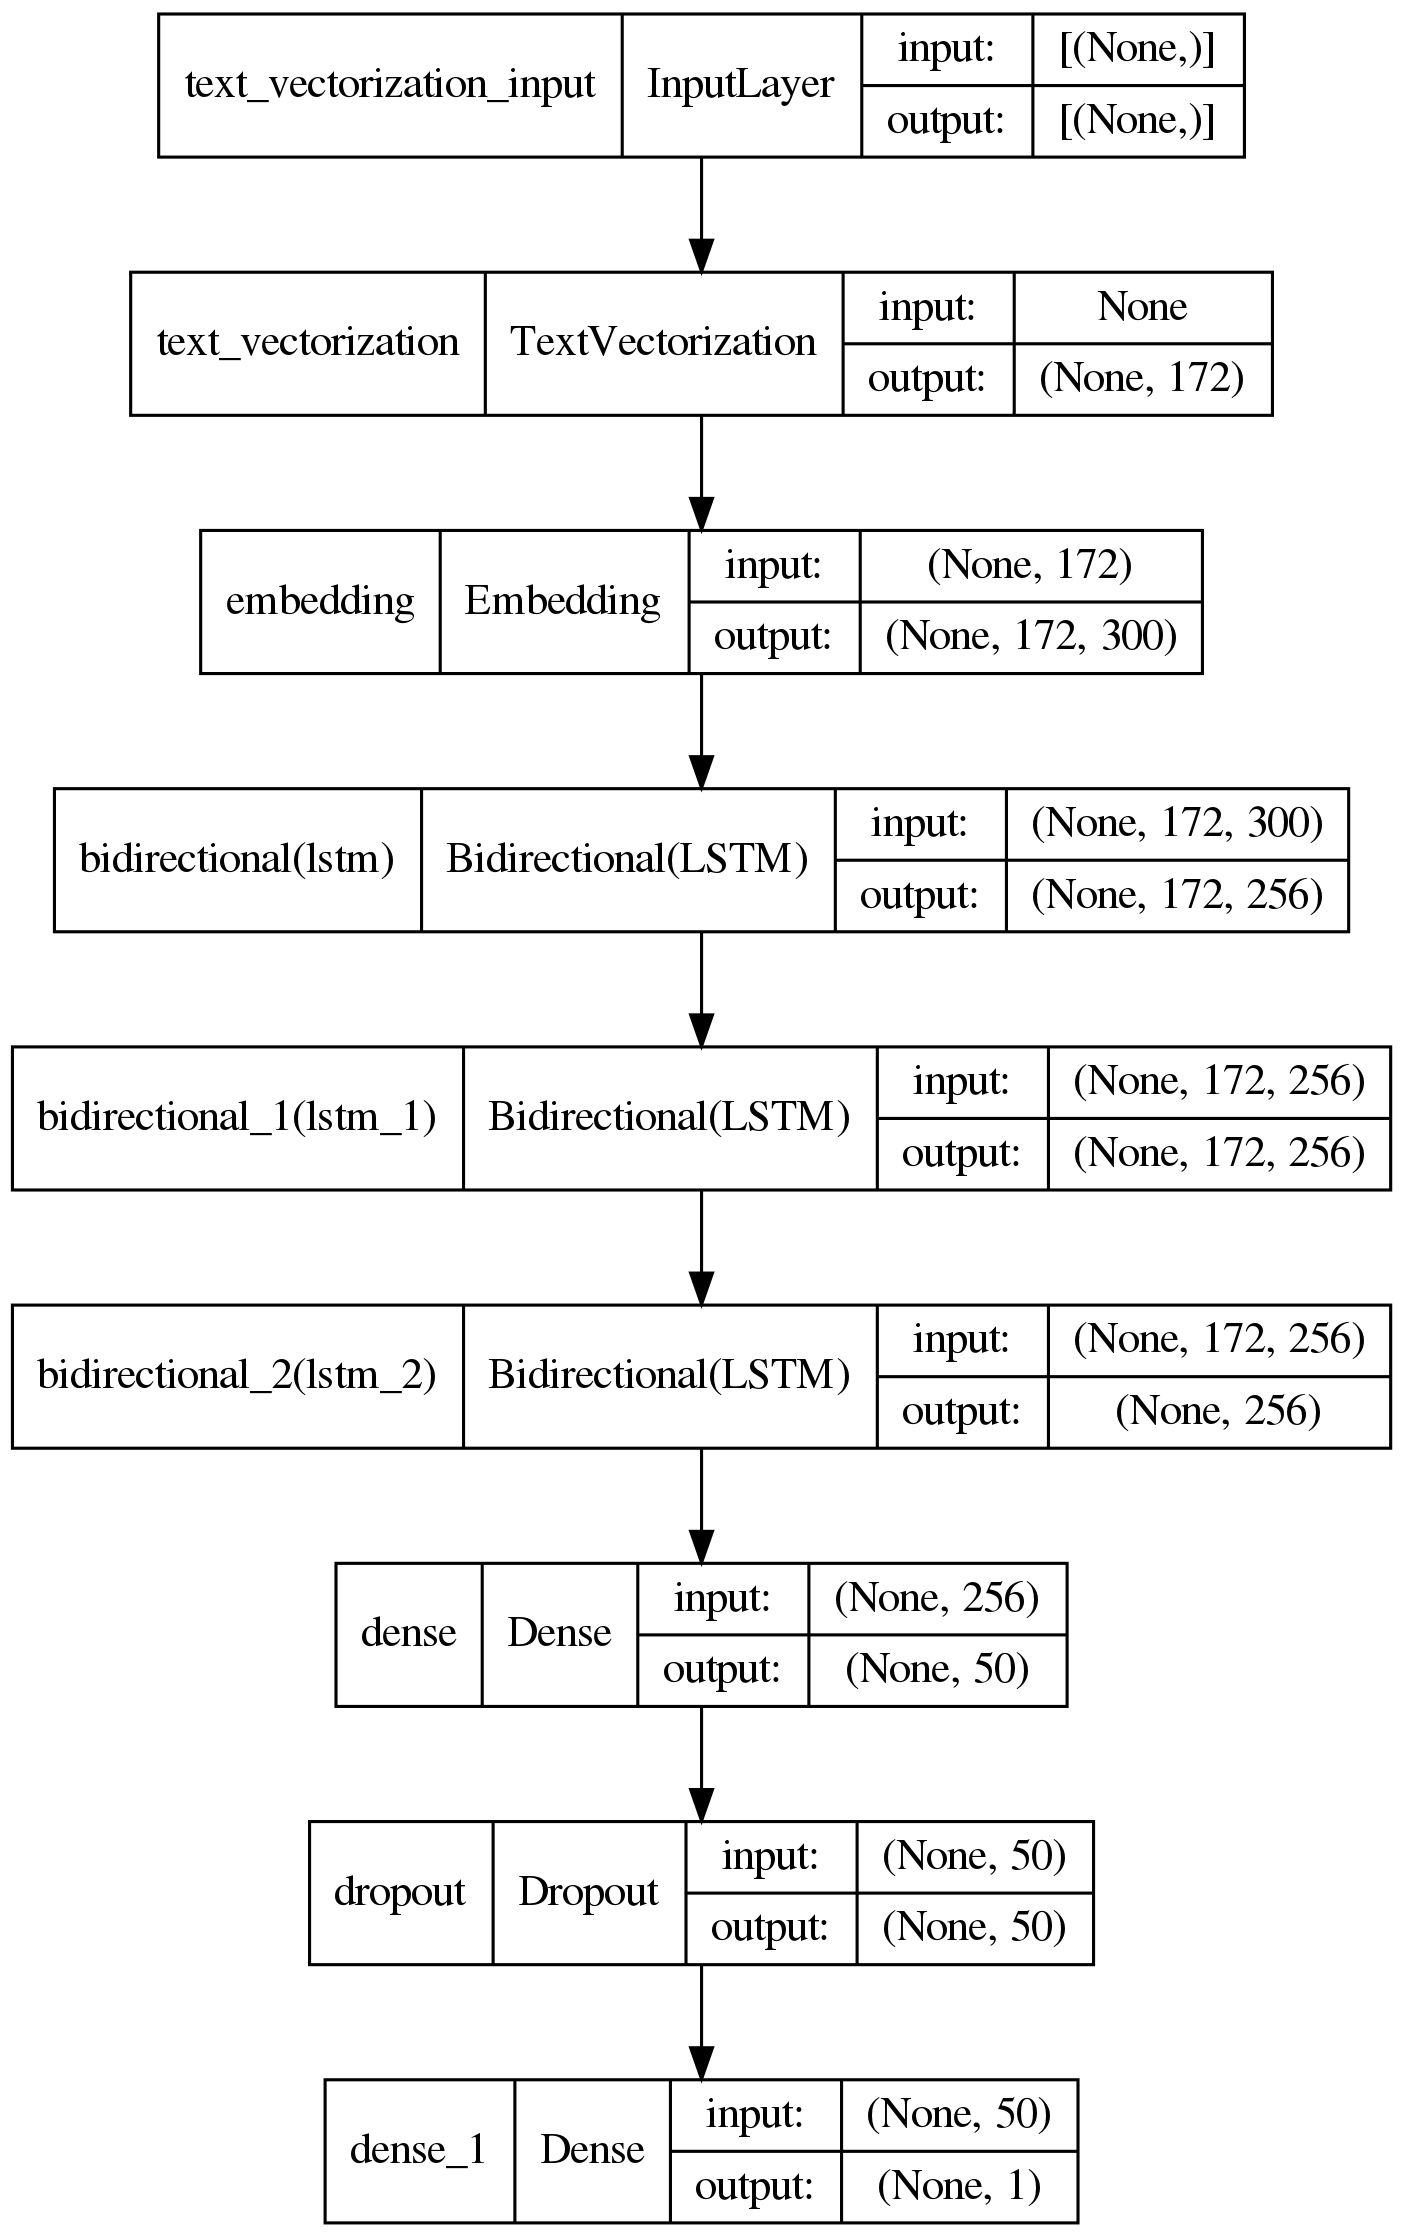

In [26]:
tf.keras.utils.plot_model(model, "model.png", dpi=224, show_shapes=True)

In [28]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
wandb_callback = WandbCallback(
    monitor="val_f1",
    mode="max",
    validation_data=val_ds,
    save_model=False
)
callbacks = [
             wandb_callback,
             EarlyStopping(patience=10, monitor="val_f1", mode="max", restore_best_weights=True),
             ReduceLROnPlateau()

]

In [29]:
config.epochs = 50

In [30]:

model.fit(train_ds, validation_data=val_ds, epochs=config.epochs, batch_size=config.batch_size, callbacks=callbacks, class_weight=class_weights)
run.finish()

Epoch 1/50
192/192 [==============================] - 36s 117ms/step - loss: 1.0551 - acc: 0.6511 - f1: 0.5853 - precision: 0.4993 - recall: 0.7070 - val_loss: 0.7349 - val_acc: 0.6439 - val_f1: 0.6101 - val_precision: 0.4931 - val_recall: 0.8000 - lr: 0.0010
Epoch 2/50
192/192 [==============================] - 18s 95ms/step - loss: 0.6453 - acc: 0.6890 - f1: 0.6225 - precision: 0.5391 - recall: 0.7364 - val_loss: 0.6781 - val_acc: 0.6518 - val_f1: 0.6170 - val_precision: 0.5000 - val_recall: 0.8056 - lr: 0.0010
Epoch 3/50
192/192 [==============================] - 17s 90ms/step - loss: 0.6156 - acc: 0.6970 - f1: 0.6316 - precision: 0.5476 - recall: 0.7460 - val_loss: 0.6260 - val_acc: 0.6761 - val_f1: 0.6127 - val_precision: 0.5249 - val_recall: 0.7359 - lr: 0.0010
Epoch 4/50
192/192 [==============================] - 17s 91ms/step - loss: 0.5963 - acc: 0.7048 - f1: 0.6389 - precision: 0.5565 - recall: 0.7500 - val_loss: 0.6352 - val_acc: 0.6707 - val_f1: 0.6115 - val_precision: 0.51

acc,▁▃▄▄▅▅▅▆▆▆▇▇▇▇█▄
epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇██
f1,▁▃▄▄▄▄▅▅▆▆▇▇▇▇█▅
loss,█▃▂▂▂▂▂▂▂▁▁▁▁▁▁▂
precision,▁▃▄▄▅▅▅▆▆▇▇▇▇▇█▄
recall,▁▃▃▄▃▃▄▅▅▅▆▆▆▇█▇
val_acc,▁▂▄▃█▅█▄▆▆▇▄▅▇▆▅
val_f1,▆▇▇▆▇█▃▇▇▇▅▅██▇▁
val_loss,█▅▂▃▂▃▁▃▂▃▂▄▄▃▅█
val_precision,▁▁▃▃█▄█▄▆▅▇▄▄▇▅▄
val_recall,██▆▆▃▆▁▆▄▄▂▄▅▄▄▂


In [32]:
model.evaluate(X_test, y_test)

128/128 [==============================] - 7s 32ms/step - loss: 0.6115 - acc: 0.7105 - f1: 0.6480 - precision: 0.5618 - recall: 0.7655


[0.6114904880523682,
 0.7104682326316833,
 0.647987961769104,
 0.5617570877075195,
 0.7654929757118225]

### Architecture Search

In [ ]:
run = wandb.init(
    project='dele_ca1_paper',
    config = {
        "batch_size" : 64,
        "loss_function" : "binary_crossentropy",
        "architecture" : "Architecture Search LSTM dim Common Crawl 42B tokens Class Weight",
        "dataset" : "Implicit Hate V1 STG 1",
        "preprocessing": "remove-stop-words"
    }
)
config = wandb.config


In [ ]:
from tensorflow_addons.metrics import F1Score

In [ ]:
def build_model(hp):
  hp_units = hp.Choice('units', [64, 128, 256, 300, 512])
  hp_clasunits = hp.Choice('clas_units', [64, 128, 256, 300, 512])
  hp_hidden_layers = hp.Choice('layers', [1, 2, 3])
  hp_class_layers = hp.Choice('layers', [0, 1, 2])
  hp_weight_decay = 0.001 #hp.Float("L2 Weight Decay", 0.001, 0.01, sampling="log")
  model = Sequential([
    tokenizer,
    embedding,
    tfl.Bidirectional(tfl.LSTM(hp_units, return_sequences=(hp_hidden_layers != 1), kernel_regularizer=l2(hp_weight_decay), input_shape=(max_words, max_seqlen))),         
  ])
  for i in range(hp_hidden_layers - 1):
    model.add(
        tfl.Bidirectional(tfl.LSTM(hp_units, return_sequences=(i != hp_hidden_layers - 2), kernel_regularizer=l2(hp_weight_decay)))
    )
  for i in range(hp_class_layers):
    model.add(
        tfl.Dense(hp_clasunits, activation='relu', kernel_regularizer=l2(hp_weight_decay))
    )
    model.add(tfl.Dropout(0.2))
  model.add(
    tfl.Dense(1, activation='sigmoid', kernel_regularizer=l2(hp_weight_decay))
  )

  hp_learning_rate = 0.01 #hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
  optimizer = 'adam'
  model.compile(
      optimizer=optimizer, loss="binary_crossentropy", metrics=[
                                                                'accuracy',
                                                                Precision(),
                                                                Recall(),
                                                                F1Score(num_classes=1, name="f1", threshold=0.5)
      ]
  )
  return model

In [ ]:
tokenizer = create_tokenizer(train_ds, max_words, max_seqlen, standardize=text_preprocessor)
vocabulary = tokenizer.get_vocabulary()
embedding = load_pretrained_embeddings_v1("/content/drive/MyDrive/Data/DELE CA1/Technical Paper/Embeddings/glove.42B.300d.txt", 300, vocabulary=vocabulary, max_words=max_words, max_seqlen=max_seqlen)

In [ ]:
!rm untitled_project -rf

In [ ]:
tuner = kt.Hyperband(
    build_model,
    objective=kt.Objective("val_f1", direction="max"),
)

In [ ]:
tuner.search(train_ds, validation_data=val_ds, epochs=100)

Trial 56 Complete [00h 01m 00s]
val_f1: 0.5858091711997986

Best val_f1 So Far: 0.6041522026062012
Total elapsed time: 00h 43m 59s

Search: Running Trial #57

Hyperparameter    |Value             |Best Value So Far 
units             |300               |300               
clas_units        |64                |256               
layers            |3                 |1                 
tuner/epochs      |2                 |2                 
tuner/initial_e...|0                 |0                 
tuner/bracket     |4                 |4                 
tuner/round       |0                 |0                 

Epoch 1/2
192/192 [==============================] - 40s 158ms/step - loss: 1.1644 - accuracy: 0.6699 - precision: 0.5479 - recall: 0.2981 - f1: 0.3861 - val_loss: 0.6948 - val_accuracy: 0.6807 - val_precision: 0.6545 - val_recall: 0.1761 - val_f1: 0.2775
Epoch 2/2
192/192 [==============================] - ETA: 0s - loss: 0.6540 - accuracy: 0.7113 - precision: 0.6348 - recall: 0.4

ResourceExhaustedError: ignored

In [ ]:
tuner.get_best_hyperparameters(num_trials=1)[0]

# ULMFiT (Transfer Learning with LSTM)

### FastAI Implementation

In [66]:
run = wandb.init(
    project='dele_ca1_paper',
    config = {
        "batch_size" : 64,
        "loss_function" : "binary_crossentropy",
        "architecture" : "ULMFiT",
        "dataset" : "Implicit Hate V1 STG 1",
        "preprocessing": "Spacy Tokenizer"
    }
)
config = wandb.config


In [42]:
tf.keras.backend.clear_session()

In [8]:
from fastai.metrics import accuracy, F1Score, Precision, Recall
from fastai.text import *
from fastai import *

In [9]:
from fastai.callback.wandb import WandbCallback

In [10]:
import fastai.text as ft
from fastai.text.all import *

In [11]:
from fastai.callback.tracker import  TerminateOnNaNCallback, SaveModelCallback

In [12]:
from fastai.text.data import TextDataLoaders

In [71]:
df_train, df_test = train_test_split(df_bin, random_state=42, test_size=0.2)
df_train = df_train[["spellchecked_post", "class"]]
df_test = df_test[["spellchecked_post", "class"]]

In [42]:
data_lm = TextDataLoaders.from_df(
   df_train,
   "data",
   valid_pct=0.25,
   seed=42, 
   is_lm=True,
   bs=64,
   seq_len=max_seqlen
)

# data_lm_bwd = TextDataLoaders.from_df(
#    df_train,
#    "data",
#    valid_pct=0.25,
#    seed=42, 
#    is_lm=True,
#    backwards=True,
#    bs=64,
#    seq_len=max_seqlen
# )

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [ ]:
# from fastai.text.data import TextLMDataBunch, TextClasDataBunch
# data_lm = TextLMDataBunch.from_df(
#     "dataset",
#     train_df = pd.concat([X_train, y_train], axis=1),
#     valid_df = pd.concat([X_val, y_val], axis=1),
#     test_df = pd.concat([X_test, y_test], axis=1),
#     text_cols=["post"], label_cols=["class"], bs=BATCH_SIZE
# )
# data_lm.save("data_lm.pkl")
# data_clas = TextClasDataBunch.from_df(
#     "dataset",
#     train_df = pd.concat([X_train, y_train], axis=1),
#     valid_df = pd.concat([X_val, y_val], axis=1),
#     test_df = pd.concat([X_test, y_test], axis=1),
#     text_cols=["post"], label_cols=["class"],
#     vocab=data_lm.train_ds.vocab, bs=BATCH_SIZE
# )


ImportError: ignored

In [ ]:
# data_clas.save("data_clas.pkl")
# data_clas_bwd = load_data("/content/dataset", 'data_clas.pkl', bs=BATCH_SIZE, backwards=True)

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [ ]:
# data_bwd = load_data("/content/dataset", 'data_lm.pkl', bs=BATCH_SIZE, backwards=True)

In [43]:
data_lm.show_batch()

,text,text_
0,xxbos let him whine for his illegals money xxbos * blocks your path * thanks for 3 xxrep 4 0 followers ! now go forth and honor your ancestors by building a world fit for your descendants . xxbos what can you do for the cause ? here 's your answer : # whitegenocide # 14words wakeup xxbos # xxunk < = this is an ethnic cleansing operation to drive away xxunk to afghanistan . same as in xxunk against xxunk muslims and block xxbos let 's start with the difference between a white supremacist and a white extremist can you tell ? xxbos i have a need to hang out with people that are different than me . people o xxbos about the recent auschwitz article from the independent . : can anyone shed light on what xxunk morning 's xxunk … xxbos let them got maybe we can,let him whine for his illegals money xxbos * blocks your path * thanks for 3 xxrep 4 0 followers ! now go forth and honor your ancestors by building a world fit for your descendants . xxbos what can you do for the cause ? here 's your answer : # whitegenocide # 14words wakeup xxbos # xxunk < = this is an ethnic cleansing operation to drive away xxunk to afghanistan . same as in xxunk against xxunk muslims and block xxbos let 's start with the difference between a white supremacist and a white extremist can you tell ? xxbos i have a need to hang out with people that are different than me . people o xxbos about the recent auschwitz article from the independent . : can anyone shed light on what xxunk morning 's xxunk … xxbos let them got maybe we can get
1,white crowd . xxbos this is just another good reason for white southerners to quit giving their money to the ifl . xxbos he white xxbos unless white america will step up & have more kids our total economy will tank trying to pay is for baby boomer xxunk i / o daca xxbos you do understand back on 1790 you were n't considered white xxbos canada has a strong national identity that s welcoming to immigrants and makes immigrants want to assimilate xxbos anyone of european heritage is xxunk is basic stuff . xxbos charlottesville 2.0 : xxunk xxunk 's xxunk xxunk via xxbos xxmaj to all the black kids without fathers do n't be so upset xxmaj in a few years you 'll get to meet them when you go to prison xxbos hopefully this was done in white neighborhoods . xxbos cheese eating surrender monkeys who know,crowd . xxbos this is just another good reason for white southerners to quit giving their money to the ifl . xxbos he white xxbos unless white america will step up & have more kids our total economy will tank trying to pay is for baby boomer xxunk i / o daca xxbos you do understand back on 1790 you were n't considered white xxbos canada has a strong national identity that s welcoming to immigrants and makes immigrants want to assimilate xxbos anyone of european heritage is xxunk is basic stuff . xxbos charlottesville 2.0 : xxunk xxunk 's xxunk xxunk via xxbos xxmaj to all the black kids without fathers do n't be so upset xxmaj in a few years you 'll get to meet them when you go to prison xxbos hopefully this was done in white neighborhoods . xxbos cheese eating surrender monkeys who know nothing
2,mean i like … white people ? because the us was native american land before it was stolen . xxbos black and white people against the elite 1 % i who are happy for us to fight xxbos : anarcho - tyranny : the corruption of charlottesville i va via xxbos ice agents outnumbered 5 to 11 xxrep 3 0 illegals i cheer new trump hires via xxbos supreme court will xxunk a decision june 2018 i i ask why ? if a jury took that long to xxbos minneapolis xxunk candidate raymond xxunk proposes disarming cops after muslim cop kills unarmed woman xxbos the parties changed their positions . gop started out liberal . dems were originally conservative . started changing in the late is xxbos why do nt the british take the dreamers they are here illegally and need to be deported only 45 % of dreamers have,i like … white people ? because the us was native am

In [ ]:
data_lm_bwd.show_batch()

,text,text_
0,"! you serve can we how know us let . liberty religious for us with standing for thanks xxbos ! ! heart xxunk xxunk my ! jean sally and jean bobby jean xxunk see go to bout 'm i . pa and ma did sure i xxbos away audience the xxunk always xxunk their , xxunk the ? band xxunk 's muslim a is what xxbos via immigration white - non and britain about facts real the : race white the of extermination the xxbos ! ! pm one only xxunk india that her inform not does & india of whole for pm be shld modi that xxunk hillary queen xxunk xxunk xxbos "" "" "" stupid stay "" "" ! slogan new your found i ! ? "" "" white stay "" xxbos xxunk and polos white their in . saturday every larpers stupid be must xxunk xxunk georgia","you serve can we how know us let . liberty religious for us with standing for thanks xxbos ! ! heart xxunk xxunk my ! jean sally and jean bobby jean xxunk see go to bout 'm i . pa and ma did sure i xxbos away audience the xxunk always xxunk their , xxunk the ? band xxunk 's muslim a is what xxbos via immigration white - non and britain about facts real the : race white the of extermination the xxbos ! ! pm one only xxunk india that her inform not does & india of whole for pm be shld modi that xxunk hillary queen xxunk xxunk xxbos "" "" "" stupid stay "" "" ! slogan new your found i ! ? "" "" white stay "" xxbos xxunk and polos white their in . saturday every larpers stupid be must xxunk xxunk georgia entire"
1,xxunk a is caucasian . color a 's it race a not is white so think n't do xxbos white n't are jews ? otherwise or right alt movement identity white of sort any of part a be jew a could how xxbos seat back the in 50 $ a toss xxmaj ? xxunk xxmaj a of seat back the in jews 20 get you do how xxmaj xxbos groups hate democrat racist both are klan the and antifa yes xxbos . sentence a beginning & xxunk : exceptions . white in w the capitalize never jews plus . them to gets really it . jew in j the capitalize n't do xxbos hispanic legal separate we about how and ? asians are where . graphic poor a such is this xxbos d sociology sure pretty 'm i . bad pretty is it yeah so evil inherently is racism well,a is caucasian . color a 's it race a not is white so think n't do xxbos white n't are jews ? otherwise or right alt movement identity white of sort any of part a be jew a could how xxbos seat back the in 50 $ a toss xxmaj ? xxunk xxmaj a of seat back the in jews 20 get you do how xxmaj xxbos groups hate democrat racist both are klan the and antifa yes xxbos . sentence a beginning & xxunk : exceptions . white in w the capitalize never jews plus . them to gets really it . jew in j the capitalize n't do xxbos hispanic legal separate we about how and ? asians are where . graphic poor a such is this xxbos d sociology sure pretty 'm i . bad pretty is it yeah so evil inherently is racism well uh
2,"hook sandy after like . right are they think i frankly , well ' plan a has god ' hear i often xxunk after . god same the to pray all religions major most understand i what from xxbos training xxunk wants right alt xxbos "" 1m1w # prop8 # scotus # "" "" . begun just only has marriage over debate the decision courts supreme the despite "" xxbos antifa like looks it and fires xxunk some add just xxbos folks white of xxunk loser amongst commonly more found is rage the fascists racist of study my on based xxbos xxunk a of less slightly be to starting xxbos . white born were jews most and . white born be would they he well xxbos law sharia implement : caliphate ! jihad xxbos days four than more for jihadis taliban hold n't ca soldiers british : judge uk :","sandy after like . right are they think i frankly , well ' plan a has god ' hear i often xxunk after . god same the to pray all religions major most understand i what from xxbos training xxunk wants right alt xxbos "" 1m1w # prop8 # scotus # "" "" . begun just only has marriage over debate the decision courts supreme the despite "" xxbos antifa like looks it and fires xxunk some add

In [20]:
callbacks=[EarlyStoppingCallback(patience=5), SaveModelCallback()]

In [44]:
learn = language_model_learner(data_lm, AWD_LSTM, metrics=[accuracy], path="data", wd=0.1, cbs=callbacks)
# learn.to_fp16(clip=0.1) # mixed precision training
# learn.lr_find()

In [45]:
lr = 0.00363078061491251

In [46]:
learn.fit_one_cycle(1, lr)

epoch,train_loss,valid_loss,accuracy,time
0,6.516709,5.972650,0.123700,00:13


Better model found at epoch 0 with valid_loss value: 5.972650051116943.


In [47]:
learn.freeze_to(-2)
lr = lr / 2

In [48]:
learn.fit_one_cycle(5, slice(lr/(2.6**4), lr))

epoch,train_loss,valid_loss,accuracy,time
0,5.966788,5.348662,0.152604,00:13
1,5.645183,5.087703,0.182071,00:13
2,5.452581,4.987474,0.190834,00:13
3,5.329210,4.950447,0.194335,00:13
4,5.253724,4.943402,0.194987,00:13


Better model found at epoch 0 with valid_loss value: 5.34866189956665.
Better model found at epoch 1 with valid_loss value: 5.087703227996826.
Better model found at epoch 2 with valid_loss value: 4.987473964691162.
Better model found at epoch 3 with valid_loss value: 4.950447082519531.
Better model found at epoch 4 with valid_loss value: 4.94340181350708.


In [49]:
learn.unfreeze()
lr = lr / 2

In [50]:
learn.fit_one_cycle(5, slice(lr/(2.6**4), lr))

epoch,train_loss,valid_loss,accuracy,time
0,5.110404,4.907133,0.198529,00:13
1,5.070982,4.847001,0.202094,00:13
2,5.020296,4.806017,0.206792,00:13
3,4.986125,4.788654,0.209079,00:13
4,4.959718,4.785875,0.209544,00:13


Better model found at epoch 0 with valid_loss value: 4.907133102416992.
Better model found at epoch 1 with valid_loss value: 4.847001075744629.
Better model found at epoch 2 with valid_loss value: 4.80601692199707.
Better model found at epoch 3 with valid_loss value: 4.788654327392578.
Better model found at epoch 4 with valid_loss value: 4.785874843597412.


In [51]:
learn.unfreeze()
lr = lr / 5

In [52]:
learn.fit_one_cycle(30, slice(lr/(2.6**4), lr))

epoch,train_loss,valid_loss,accuracy,time
0,4.916785,4.785231,0.209703,00:13
1,4.921052,4.783975,0.209794,00:13
2,4.919029,4.781407,0.209596,00:13
3,4.913435,4.777219,0.210379,00:13
4,4.913549,4.773616,0.210295,00:13
5,4.906997,4.765776,0.211190,00:13
6,4.896784,4.757508,0.211651,00:13
7,4.886355,4.750693,0.213232,00:13
8,4.881952,4.743795,0.213544,00:13
9,4.870254,4.735910,0.214566,00:13


Better model found at epoch 0 with valid_loss value: 4.785231113433838.
Better model found at epoch 1 with valid_loss value: 4.783974647521973.
Better model found at epoch 2 with valid_loss value: 4.781406879425049.
Better model found at epoch 3 with valid_loss value: 4.777218818664551.
Better model found at epoch 4 with valid_loss value: 4.773615837097168.
Better model found at epoch 5 with valid_loss value: 4.76577615737915.
Better model found at epoch 6 with valid_loss value: 4.757508277893066.
Better model found at epoch 7 with valid_loss value: 4.750693321228027.
Better model found at epoch 8 with valid_loss value: 4.743794918060303.
Better model found at epoch 9 with valid_loss value: 4.735909938812256.
Better model found at epoch 10 with valid_loss value: 4.730121612548828.
Better model found at epoch 11 with valid_loss value: 4.723719596862793.
Better model found at epoch 12 with valid_loss value: 4.7184247970581055.
Better model found at epoch 13 with valid_loss value: 4.71321

In [53]:
learn.save_encoder("fwd_encoder")

In [ ]:
learn.save_encoder('bwd_encoder')

In [33]:
!mv '/content/data/models/fwd_encoder.pth' '/content/drive/MyDrive/Data/DELE CA1/Technical Paper/fwd_encoder.pth'

In [72]:
df_train["class"] = (df_train["class"] == "implicit_hate").astype(int)

In [36]:
df_train = df_train[["spellchecked_post", "class"]]

In [74]:
data_clas = TextDataLoaders.from_df(
   df_train,
   "/content/drive/MyDrive/Data/DELE CA1/Technical Paper",
   valid_pct=0.25,
   seed=42, 
   bs=64,
   seq_len=max_seqlen
)

# data_clas_bwd = TextDataLoaders.from_df(
#    df_train,
#    "/content/drive/MyDrive/Data/DELE CA1/Technical Paper",
#    valid_pct=0.25,
#    seed=42, 
#    backwards=True,
#    bs=64,
#    seq_len=max_seqlen
# )

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


In [75]:
data_clas.show_batch()

,text,category
0,"xxbos pink xxunk a man walked into a whore house and asked the man running it to give him the biggest black woman that the whore house had . the man at the counter said alright that will be number and told him to go to room number the man went up to room number and the biggest black woman he had ever seen answered the door . the man walked in and asked the woman to take off all her clothes , lay on the bed and spread her legs . repeat she did as she was told , the man stood there and just looked at her for a minute , then he said ok i i finished you can put your clothes back on . repeat the woman got up and was confused as she asked , "" why did it you do xxunk ? "" the",1
1,"xxbos a black guy goes to a doctor is office to get a xxunk . he shows up in a limo wearing a xxunk . when it is his turn , the doctor looks at him and says , "" i i 've seen a lot of things , but i i 've never seen a guy coming in all dressed up like that ! "" and the black guy says , "" well , if i am gon na be i m - po - tent , i am gon na look i m - po - tent ! """,1
2,xxbos xxmaj what will you do today to disrupt disturb and xxunk the enemy ah good question xxmaj glad you asked . xxunk 1 \t 1 \t 0 \t 1 xxwrep 7 0 \t 1 \t 0 \t 0 xxunk xxunk \t xxmaj it 's a shame we stopped bombing you xxmaj die soon there 's a good little xxunk . xxunk 0 \t 1 \t 1 \t 0 \t 0 \t 1 xxwrep 5 0 \t 1 \t 0 \t 0 xxunk xxunk \t xxmaj more black teens should end up like xxunk aka est xxunk,1
3,"xxbos i it oh i i love this ! ! thank you for all of your efforts . i live in atlanta and it has changed xxunk in just five years ( not for the better ) . we have i "" logo "" "" zones and the like . most don ; i realize how bad it is because they go from car to house to work . it 's bad i folks ! """,0
4,xxbos xxmaj london police arrest two men in connection with the xxmaj london xxmaj terrorist xxmaj bombing i one 18 yrs old i one 21 yrs old i xxmaj wo n't tell us xxunk they are but i can just about tell you xxunk they xxup are n't i xxmaj white / xxmaj european xxmaj british xxmaj native xxmaj londoners xxup iq above room xxunk xxmaj self - sufficient i xxmaj any xxunk at xxunk ?,1
5,"xxbos xxmaj in my humble opinion the ethic solution is the xxunk available because its my duty as member of society to kill those who tries to attack my family and destroy my country xxmaj also its okay to xxunk those who will be like "" sh xxrep 4 i xxup et , xxup do nt xxup you xxup have xxup no heart xxup they 're k xxrep 5 i xxup xxunk , dude",1
6,xxbos xxmaj some guy in my school started talking that way xxunk along with some other xxunk xxunk funny when he came out and we all just said we know [ … ] i read somewhere that your true accent is the accent you speak when you are drunk or angry as the cognitive load present in putting on a fake accent xxunk or xxunk,1
7,xxbos xxmaj the ok suckers at twitter have permanently suspended xxunk xxunk xxunk for suggesting an xxup xxunk strike on invaders trying to enter our country from the southern border i think this is why xxmaj no reason was given to me from the communist at twitter xxmaj what a shame xxmaj twitter is now run by and for leftist gun - xxunk commies,1
8,xxbos i keep having to say this in response to twitter accusations . i do n't hate the whites . i am white i most of my friends are white i most of the women i 've dated have been white . i 'm huge with the whites the whites love me . and again i whites also make the best beer .,0


In [76]:
clas_model = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5, metrics=[accuracy, F1Score(), Precision(), Recall()], cbs=[
  SaveModelCallback(monitor="f1_score"),
  EarlyStoppingCallback(monitor="f1_score", patience=5),
  WandbCallback()
])

In [77]:
clas_model.load_encoder("/content/data/models/fwd_encoder")

SuggestedLRs(valley=0.001737800776027143)

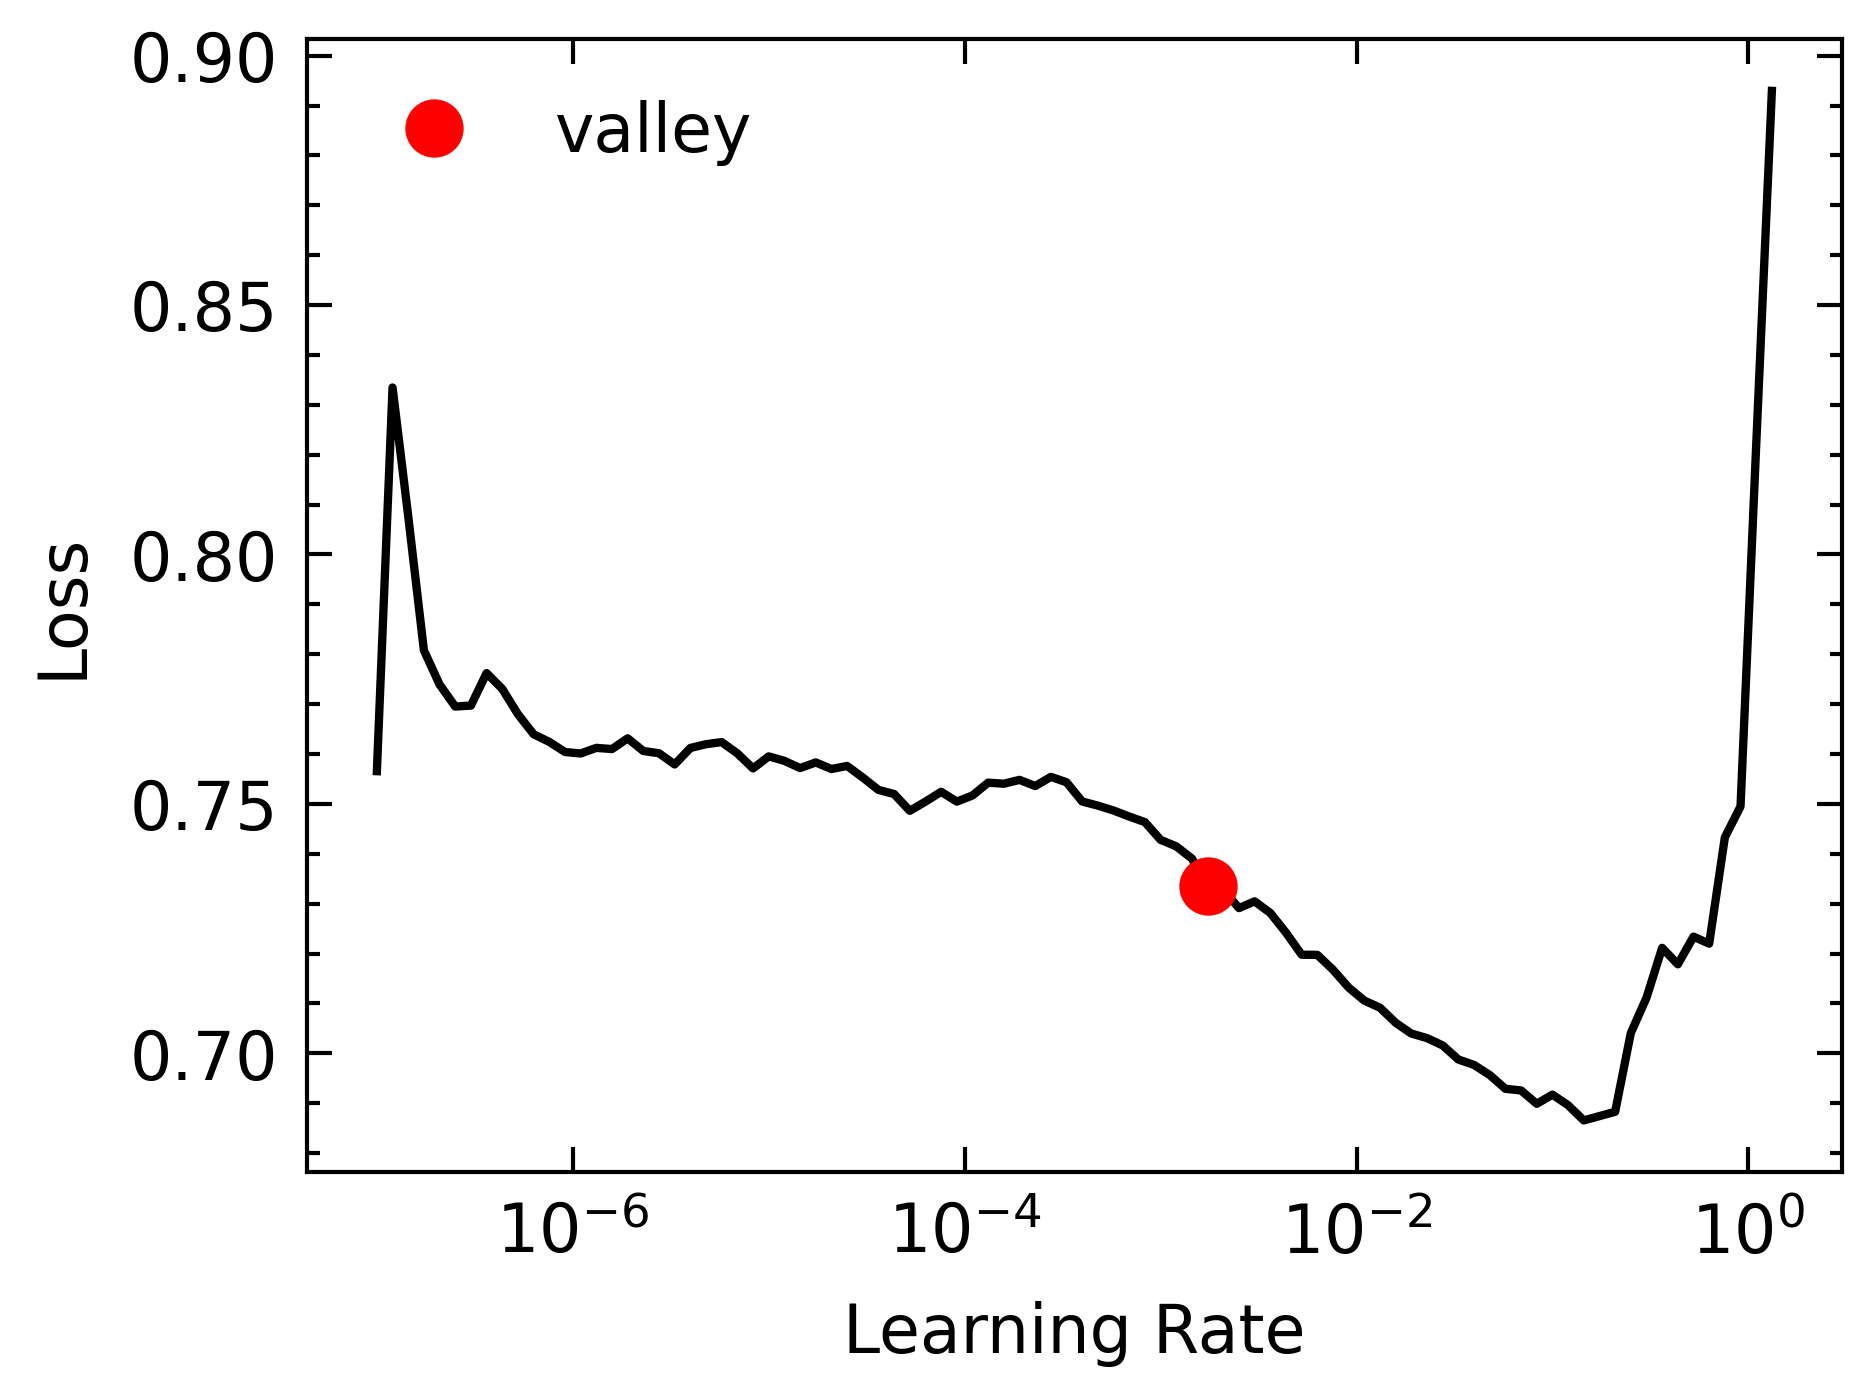

In [59]:
clas_model.lr_find()

In [78]:
# lr =  1e-1 / 2 / 2
lr = 0.001737800776027143 #0.00363078061491251
print(lr)

0.001737800776027143


In [79]:
clas_model.fit_one_cycle(10, lr, wd=0.1)

WandbCallback was not able to prepare a DataLoader for logging prediction samples -> unhashable type: 'L'


epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.638324,0.589302,0.685630,0.557015,0.557015,0.557015,00:08
1,0.589457,0.560744,0.705493,0.566269,0.593041,0.541811,00:08
2,0.567260,0.548730,0.720451,0.513237,0.671508,0.415342,00:08
3,0.544346,0.540459,0.725601,0.564083,0.646429,0.500346,00:08
4,0.539392,0.525283,0.734674,0.551410,0.689119,0.459572,00:08
5,0.527559,0.529356,0.735900,0.586881,0.659483,0.528680,00:08
6,0.525315,0.527732,0.735409,0.543377,0.700873,0.443677,00:08
7,0.522694,0.524727,0.741295,0.535856,0.737288,0.420871,00:08
8,0.502290,0.522088,0.735164,0.563460,0.678676,0.481686,00:08
9,0.497796,0.520715,0.739578,0.560430,0.698658,0.467865,00:08


Better model found at epoch 0 with f1_score value: 0.5570145127850725.
Better model found at epoch 1 with f1_score value: 0.5662694113398339.
Better model found at epoch 5 with f1_score value: 0.5868814729574223.


In [80]:
clas_model.freeze_to(-2)

In [81]:
lr /= 2
clas_model.fit_one_cycle(10, slice(lr/(2.6**4), lr), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.521325,0.521090,0.742030,0.551577,0.719689,0.447132,00:08
1,0.523541,0.520856,0.744237,0.609510,0.665033,0.562543,00:08
2,0.519411,0.515468,0.743502,0.590767,0.680794,0.521769,00:08
3,0.504470,0.515675,0.739088,0.557404,0.700104,0.463027,00:08
4,0.482578,0.515976,0.744728,0.594468,0.681250,0.527298,00:08
5,0.465910,0.511986,0.749877,0.587379,0.708293,0.501728,00:08
6,0.458933,0.516489,0.750613,0.585406,0.713718,0.496199,00:08


Better model found at epoch 0 with f1_score value: 0.5515771526001705.
Better model found at epoch 1 with f1_score value: 0.6095095469861475.
No improvement since epoch 1: early stopping


In [82]:
clas_model.freeze_to(-3)
lr /= 2
clas_model.fit_one_cycle(10, slice(lr/(2.6**4), lr), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.500977,0.515101,0.744973,0.577922,0.700098,0.492053,00:09
1,0.492182,0.511655,0.749142,0.570709,0.726496,0.469938,00:09
2,0.489867,0.507754,0.748897,0.583062,0.709613,0.494817,00:09
3,0.474328,0.510129,0.744483,0.602896,0.672048,0.546648,00:09
4,0.458234,0.510640,0.750858,0.600943,0.696087,0.528680,00:09
5,0.433885,0.511701,0.742521,0.601064,0.667511,0.546648,00:09
6,0.418491,0.515661,0.747180,0.622483,0.661994,0.587422,00:09
7,0.412195,0.510599,0.749387,0.608429,0.682717,0.548721,00:09
8,0.406204,0.514270,0.750858,0.608930,0.687228,0.546648,00:09
9,0.413626,0.513566,0.748651,0.596298,0.693223,0.523151,00:09


Better model found at epoch 0 with f1_score value: 0.577922077922078.
Better model found at epoch 2 with f1_score value: 0.5830618892508144.
Better model found at epoch 3 with f1_score value: 0.6028963414634148.
Better model found at epoch 6 with f1_score value: 0.622482607103625.


In [83]:
clas_model.unfreeze()
lr /= 5
clas_model.fit_one_cycle(20, slice(lr/(2.6**4), lr), wd=0.1)

epoch,train_loss,valid_loss,accuracy,f1_score,precision_score,recall_score,time
0,0.413574,0.517064,0.749632,0.584453,0.710891,0.496199,00:10
1,0.418670,0.514927,0.747425,0.616530,0.668281,0.572218,00:10
2,0.416667,0.515660,0.748406,0.601708,0.686448,0.535591,00:10
3,0.409154,0.514203,0.750613,0.600393,0.695811,0.527989,00:10
4,0.409533,0.514105,0.748651,0.602559,0.686396,0.536973,00:10
5,0.405830,0.512174,0.746444,0.611278,0.670239,0.561852,00:09
6,0.399974,0.514219,0.745954,0.614296,0.665860,0.570145,00:10


Better model found at epoch 0 with f1_score value: 0.5844525844525844.
Better model found at epoch 1 with f1_score value: 0.616530156366344.
No improvement since epoch 1: early stopping


In [84]:
clas_model.save("/content/drive/MyDrive/Data/DELE CA1/Technical Paper/models/fwd_model")

Path('/content/drive/MyDrive/Data/DELE CA1/Technical Paper/models/fwd_model.pth')

In [86]:
X_test

19884                god forbid a child might actually think of god on the playground and we can't have that kind of religious statism now can we
2038                                                                           : anti-white racism has reached critical mass in america ( video )
19569                                              you have a lot to learn about islam these pigs are of sunni sect of islam about 75% of muslims
5837                       anyone who doesnt agree with liberal agenda is racist . so i guess your a racist i you dont agree with me . #noamnesty
9046                                                 thanks for the info . don't ever think that people like you two don't make a diff . you do !
                                                                           ...                                                                   
6720                                                                                                     a reminder that jew

In [106]:
df_test_set = pd.DataFrame({
    "spellchecked_post" : X_test,
    "class" : y_test
})

In [107]:
df_test_set

,spellchecked_post,class
19884,god forbid a child might actually think of god on the playground and we can't have that kind of religious statism now can we,1
2038,: anti-white racism has reached critical mass in america ( video ),0
19569,you have a lot to learn about islam these pigs are of sunni sect of islam about 75% of muslims,1
5837,anyone who doesnt agree with liberal agenda is racist . so i guess your a racist i you dont agree with me . #noamnesty,1
9046,thanks for the info . don't ever think that people like you two don't make a diff . you do !,0
...,...,...
6720,a reminder that jews are not white ! via,1
14585,the end of a myth : most new serial killers in america are not white males | read more :,0
7904,it's a good thing that doesn't want to gut medicare and social security like paul ryan #nrorevolt,0
12819,we hindus offer lord krishna's package to muslims--give us 3 temples and keep 39997 maids . i hope muslim leaders don't become duryodhan,1


In [108]:
df_test

,spellchecked_post,class
13063,37 % of women having abortions are white i 37 % are black i 19 % are hispanic i and 7 % other races .,not_hate
21232,what do you call a woman who thinks she can do anything a man can do ? wrong .,implicit_hate
20304,law-abiding illegal aliens is an oxymoron secure the border,implicit_hate
14133,clash of civilizations ? calls 4 new crusade i ord #whitegenocide war i designed to kill off remnants of the white race,not_hate
19021,we can't tell they have a y chromosome in every cell in their body ? pretty sure we can,not_hate
...,...,...
9105,they state that he violates american values which are jewish values . they can't stop lying ' !,not_hate
19945,no that they do not bud they shouldn't be allowed to breathe period they'll be buried in shit ridden piss soaked slate,implicit_hate
8035,oy vey ! guess who doesn't approve of blacks and whites working together in harmony !,not_hate
3153,earthquakes are painful and tragic as well . but they're not terror . yes - white people kill . doesn't automatically make it terror .,not_hate


In [105]:
df_train

,spellchecked_post,class
17980,islamists embedded in white house ? art #stopislam crusades #makedclisten #wakeupamerica,1
18305,uk : racist black man punches pregnant white girl in stomach as onlookers watch via,1
12014,your biggest problem is people associate u you guys with being basement dweller intels . dispel that not,0
7613,: white pill time : richard spencer helps to lead torchlight procession in support of white southern i,1
13441,lol . you will learn what it means to be white and proud of your race . or be foolish and face the consequences .,1
...,...,...
11848,these people using that slogan were not tied to,0
12561,new german biography casts hitler in a different light,0
5662,"i it i "" : blood & honour - white aryan resistance shirt from the white resister : "" "" ; """,0
898,why are you promoting alright white supremacy and hate ? this has nothing to do with christianity .,0


In [104]:
data_test = TextDataLoaders.from_df(
   X_test,
)

AttributeError: ignored

In [145]:
from fastai import *

In [147]:
df_test

,index,spellchecked_post,class
0,13063,37 % of women having abortions are white i 37 % are black i 19 % are hispanic i and 7 % other races .,not_hate
1,21232,what do you call a woman who thinks she can do anything a man can do ? wrong .,implicit_hate
2,20304,law-abiding illegal aliens is an oxymoron secure the border,implicit_hate
3,14133,clash of civilizations ? calls 4 new crusade i ord #whitegenocide war i designed to kill off remnants of the white race,not_hate
4,19021,we can't tell they have a y chromosome in every cell in their body ? pretty sure we can,not_hate
...,...,...,...
4074,9105,they state that he violates american values which are jewish values . they can't stop lying ' !,not_hate
4075,19945,no that they do not bud they shouldn't be allowed to breathe period they'll be buried in shit ridden piss soaked slate,implicit_hate
4076,8035,oy vey ! guess who doesn't approve of blacks and whites working together in harmony !,not_hate
4077,3153,earthquakes are painful and tragic as well . but they're not terror . yes - white people kill . doesn't automatically make it terror .,not_hate


In [154]:
df_test_text = pd.Series(df_test["spellchecked_post"], name="text")
dl = DataLoader(df_test_text)

In [170]:
clas_model.predict(df_test.iloc[2, 1])[-1].argmax()

TensorText(1)

In [174]:
y_preds = []
y_test = (df_test["class"] == "implicit_hate").astype(int)
for row in df_test.itertuples():
  post = row.spellchecked_post
  pred = clas_model.predict(post)[-1].argmax()
  y_preds.append(pred)

In [175]:
acc = accuracy_score(y_test, y_preds)
f1 = f1_score(y_test, y_preds)
precision = precision_score(y_test, y_preds)
recall = recall_score(y_test, y_preds)




In [176]:
print("Accuracy:", acc)
print("F1:", f1)
print("Precision:", precision)
print("Recall:", recall)

Accuracy: 0.7479774454523167
F1: 0.6123680241327301
Precision: 0.6617766911165445
Recall: 0.5698245614035088
